# Binary Classification of Machine Failures
---
## by Diego Garrocho

1. Intro
2. Data Analysis and transformation
3. Model Selection
4. Model Eval
5. Testing
6. Conclusion

### 1. Intro
---
Playground Prediction Competition
Binary Classification of Machine Failures
Playground Series - Season 3, Episode 17

This project aims to predict the state of Machine Failure based on a number of features. Predicting machine failure can be crucial in order to support predictive maintenance, which will support both effective business and operations management. Successfully implementing a predictive maintenance model will lower production costs while also keeping production quality high.
Binary classification is a fundamental task in machine learning where the goal is to classify input data into one of two distinct classes or categories. The two classes are typically referred to as the positive class and the negative class, or class 1 and class 0. The aim is to build a predictive model that can learn from labeled examples to accurately classify new, unseen instances into one of the two classes.

### 2. Data analysis and transformation
---
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Machine Failure Predictions. Feature distributions are close to, but not exactly the same, as the original. The data contains 14 columns, 5 of which are binary features of failure areas and 1 binary feature indicating the presence of machine failure regarding the area. The original dataset will also be used for training.

Column name needed descriptions:

UDI Universal Device Identifier
TWF Tool Wear Failure binary feature
HDF Heat Dissipation Failure binary feature
PWF Power Failure binary feature
OSF Overstain Failure binary feature
RNF Random Failure binary feature

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import xgboost as xgb
import optuna
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

C:\Users\logan\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\logan\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\logan\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
train = pd.read_csv(r'C:\Users\logan\Desktop\Binary Class for Machine Failure\train.csv')
test = pd.read_csv(r'C:\Users\logan\Desktop\Binary Class for Machine Failure\test.csv')
original = pd.read_csv(r'C:\Users\logan\Desktop\Binary Class for Machine Failure\machine failure.csv')

In [3]:
print(train.info())
print('-'*100)
print(original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [4]:
# Removind id from both and checking distributions
train_noid = train.drop('id',axis=1)
original_noid = original.drop('UDI',axis=1)

In [5]:
# Plots for train set
#for column in train_noid.columns:
    #sns.histplot(data=train_noid, x=column, kde=True)
    #plt.title(f"Distribution of {column}")
    #plt.show()

In [6]:
# Plots for original set
#for column in original_noid.columns:
    #sns.histplot(data=original_noid, x=column, kde=True)
    #plt.title(f"Distribution of {column}")
   # plt.show()

As initial analysis, both the testing and the original sets are similarly distributed in almost all features, also its now apparent that there is a high class imbalance on the target feature. There are also no missing values to deal with.

In [7]:
# Describing both sets to chech numbers
print(train_noid.describe())
print(train_noid.describe(include=['O']))
print('-'*100)
print(original_noid.describe())
print(original_noid.describe(include=['O']))

       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count        136429.000000            136429.000000           136429.000000   
mean            299.862776               309.941070             1520.331110   
std               1.862247                 1.385173              138.736632   
min             295.300000               305.800000             1181.000000   
25%             298.300000               308.700000             1432.000000   
50%             300.000000               310.000000             1493.000000   
75%             301.200000               310.900000             1580.000000   
max             304.400000               313.800000             2886.000000   

         Torque [Nm]  Tool wear [min]  Machine failure            TWF  \
count  136429.000000    136429.000000    136429.000000  136429.000000   
mean       40.348643       104.408901         0.015744       0.001554   
std         8.502229        63.965040         0.124486       0.039389

After further reading on the feature descriptions, Product ID can be dropped since it provides no useful information. Next is combining sets, encoding the object dtype, and checking correlations.

In [5]:
# Combining sets only with positives
#combined_df = pd.concat([train_noid, original_noid])

if 'Machine failure' in original_noid.columns:  # Checking if 'Machine failure' column exists in train_noid
    combined_df = pd.concat([original_noid[original_noid['Machine failure'] == 1], train_noid])
else:
    combined_df = pd.concat([train_noid, original_noid])

# Dropping id feature
combined_noid = combined_df.drop('Product ID',axis=1)

In [6]:
# Encoding the object feature with label encoding
encoder = LabelEncoder()
pret = combined_noid.copy()
pret['encoded_Type'] = encoder.fit_transform(pret['Type'])
clean = pret.drop('Type',axis=1)

In [6]:
# Splitting features by categorical/numerical
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'encoded_Type']

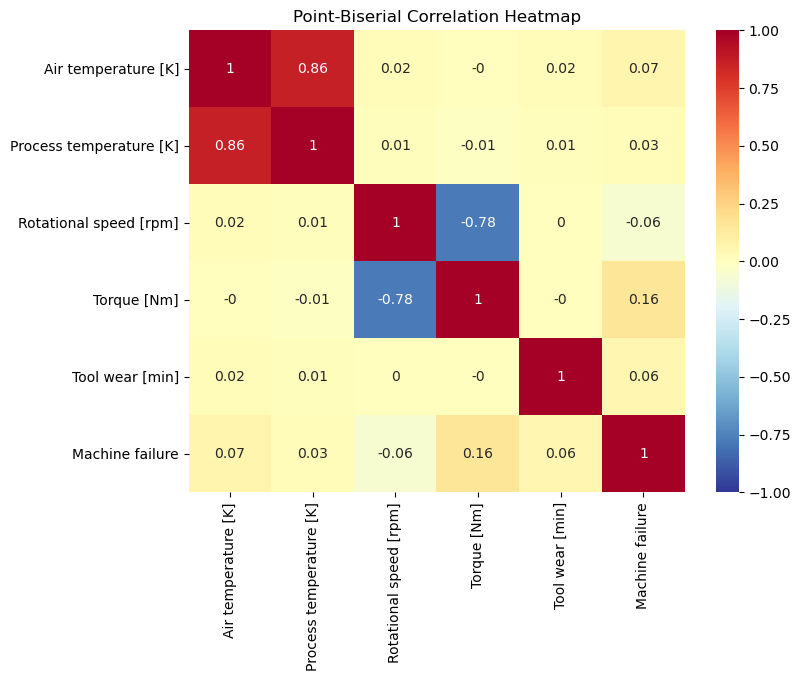

In [11]:
# Trying point-biserial correlation for numerical features
target_variable = 'Machine failure'

# Calculate the point-biserial correlation coefficients
correlation_matrix = clean[numerical_features + [target_variable]].corr().round(2)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(data=correlation_matrix, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1)
plt.title('Point-Biserial Correlation Heatmap')
plt.show()

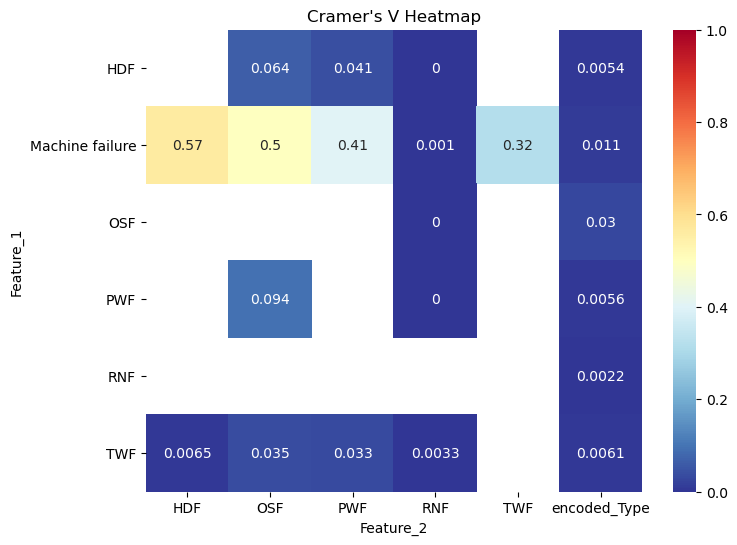

In [12]:
# Trying Cramer's V for categorical features
cramer_v_df = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'Cramer_V'])

# Iterate over pairs of categorical features
for i in range(len(categorical_features)):
    for j in range(i+1, len(categorical_features)):
        feature1 = categorical_features[i]
        feature2 = categorical_features[j]

        # Create a contingency table of the two categorical features
        contingency_table = pd.crosstab(clean[feature1], clean[feature2])

        # Calculate the chi-square statistic, p-value, and degrees of freedom
        chi2, p, dof, _ = chi2_contingency(contingency_table)

        # Calculate Cramér's V
        n = contingency_table.sum().sum()
        cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))

        # Create a new row as a DataFrame
        new_row = pd.DataFrame({'Feature_1': [feature1], 'Feature_2': [feature2], 'Cramer_V': [cramer_v]})

        # Concatenate the new row to the existing dataframe
        cramer_v_df = pd.concat([cramer_v_df, new_row], ignore_index=True)

# Create a pivot table to prepare for heatmap
pivot_table = cramer_v_df.pivot(index='Feature_1', columns='Feature_2', values='Cramer_V')

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(data=pivot_table, annot=True, cmap='RdYlBu_r', vmin=0, vmax=1)
plt.title("Cramer's V Heatmap")
plt.show()

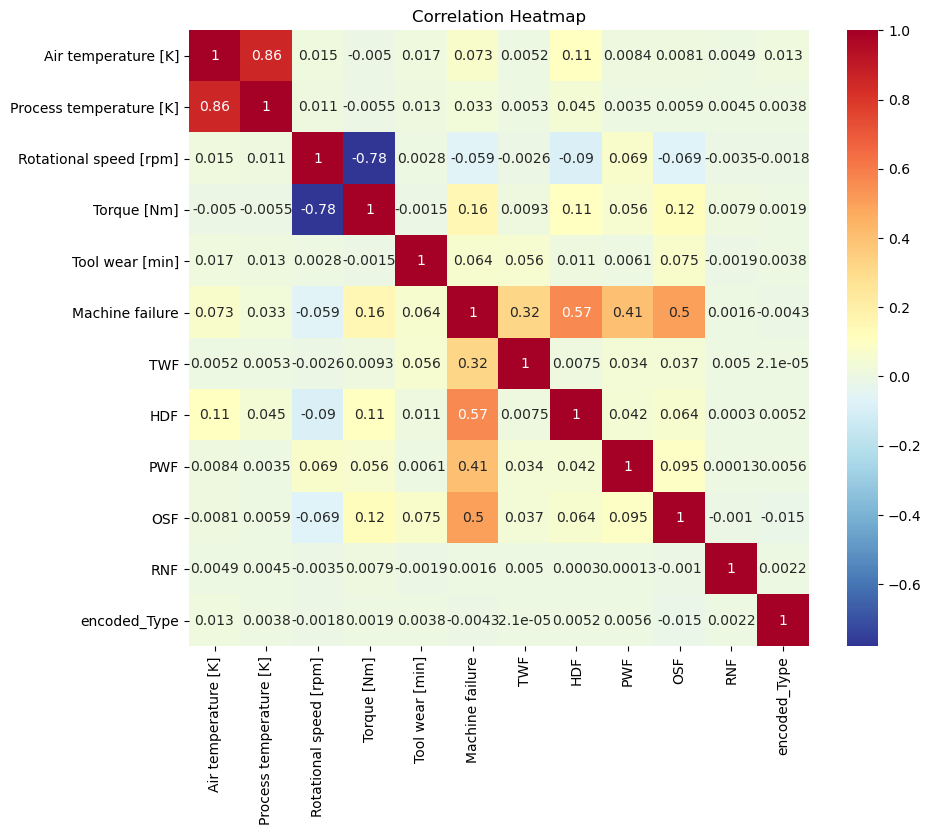

In [13]:
# Including normal corr for all dataframe
correlation_matrix = clean.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True, cmap='RdYlBu_r')
plt.title('Correlation Heatmap')
plt.show()

### Feature Engineering
---
Since there are not many features with even moderate correlation to the target, some features could be dropped and other could be added. There are probably some features that could be created out of the numerical features mainly with the speeds and temperatures since there is correlation there.

In [7]:
# Creating features
added = clean.copy()
added['Temperature ratio'] = added['Process temperature [K]'] / added['Air temperature [K]']
added['Torque * Rotational speed'] = added['Torque [Nm]'] * added['Rotational speed [rpm]']

# More complex features based on intuition
added['P temp * R speed'] = added['Process temperature [K]'] * added['Rotational speed [rpm]']
added['Temp*Speed*time'] = added['P temp * R speed'] * added['Tool wear [min]']

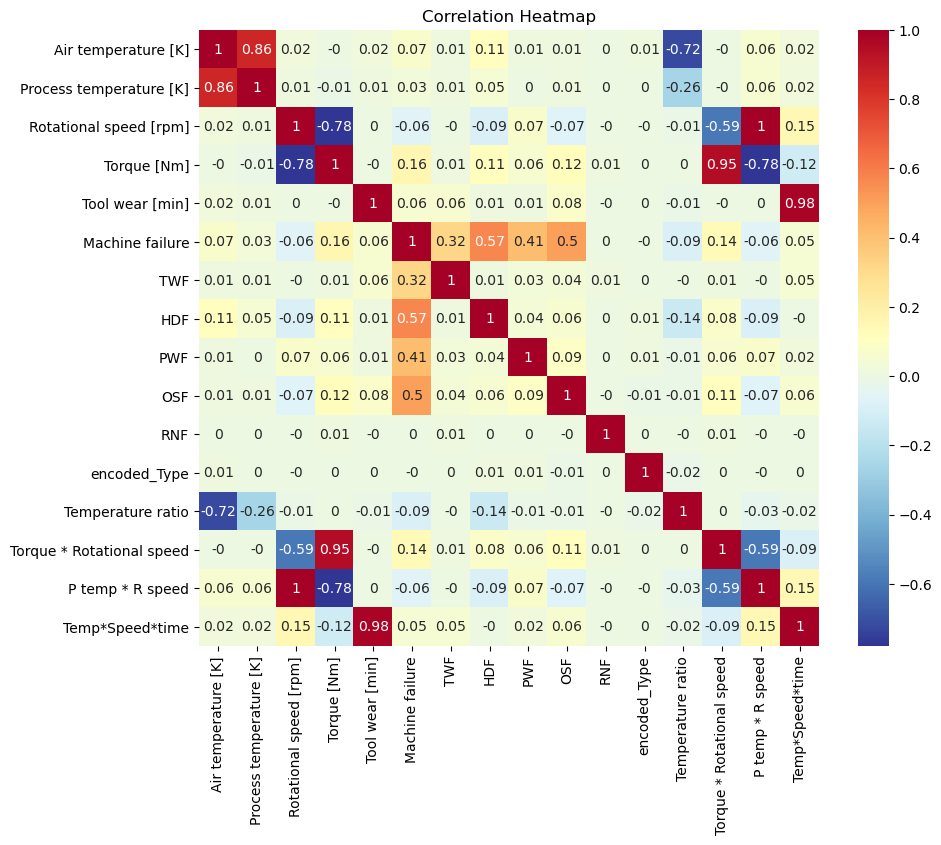

In [15]:
# Including normal corr for all dataframe
correlation_matrix = added.corr().round(2)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True, cmap='RdYlBu_r')
plt.title('Correlation Heatmap')
plt.show()

Now for feature selection, using RFE to reduce number of features later on.

In [9]:
# Reminder of class imbalance
target = added['Machine failure']
class_distribution = target.value_counts()

class_distribution_percentage = class_distribution / len(target) * 100
print(class_distribution_percentage)
print('-'*100)
print(class_distribution)

0    98.181592
1     1.818408
Name: Machine failure, dtype: float64
----------------------------------------------------------------------------------------------------
0    134281
1      2487
Name: Machine failure, dtype: int64


### 3. Model Selection
---
For the model since its a binary classification problem, an ensemble of various  gradient boosted decision trees based classifiers will be made. XGBoost, LightGBM, Catboost, and AdaBoost will be included, parameters for each will be obtained through optuna. ROC is mentioned on the competition as the evaluation method. Also using stratified K fold for cross validation.

In [10]:
# Splitting into test train sets
X = added.drop(columns=['Machine failure'])
y = target

X.columns = X.columns.astype(str)
# Replace problematic characters in feature names
X.columns = X.columns.str.replace('[', '_')
X.columns = X.columns.str.replace(']', '_')

C:\Users\logan\AppData\Local\Temp\ipykernel_7308\2055904318.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X.columns = X.columns.str.replace('[', '_')
C:\Users\logan\AppData\Local\Temp\ipykernel_7308\2055904318.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X.columns = X.columns.str.replace(']', '_')


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# XGBoost with Optuna
def objective_xgb(trial):
    params = {
        'scale_pos_weight': 54, # Negative class over Positive to calc
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        #'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.5),
        #'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        #'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'nthread': 6,
        'early_stopping_rounds': 100,
        #'tree_method': 'gpu_hist' # Trying to use GPU locally
    }

    model = xgb.XGBClassifier(**params)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        y_pred_proba = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred_proba)
        scores.append(score)

    avg_score = sum(scores) / len(scores)
    return avg_score

In [20]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

best_params_xgb = study_xgb.best_params
best_score_xgb = study_xgb.best_value

[I 2023-06-14 22:49:07,289] A new study created in memory with name: no-name-c6bc8f96-035b-43ae-b996-cffed991a95b
[I 2023-06-14 22:51:29,549] Trial 0 finished with value: 0.9696386849131782 and parameters: {'booster': 'dart', 'lambda': 0.6317134131763297, 'alpha': 0.1267297466935891, 'eta': 0.4833489729404987}. Best is trial 0 with value: 0.9696386849131782.
[I 2023-06-14 22:53:42,956] Trial 1 finished with value: 0.9706415048944754 and parameters: {'booster': 'dart', 'lambda': 0.2599640118199202, 'alpha': 0.7310881600932919, 'eta': 0.13896606282041188}. Best is trial 1 with value: 0.9706415048944754.
[I 2023-06-14 22:53:48,747] Trial 2 finished with value: 0.7811034860917137 and parameters: {'booster': 'gblinear', 'lambda': 0.6793298092096708, 'alpha': 0.3519369189303277, 'eta': 0.20676237784042406}. Best is trial 1 with value: 0.9706415048944754.
[I 2023-06-14 22:54:22,767] Trial 3 finished with value: 0.9694931624481546 and parameters: {'booster': 'gbtree', 'lambda': 0.8240597406035

In [21]:
best_model_xgb = xgb.XGBClassifier(**best_params_xgb)
#best_model.fit(X_train, y_train)

In [22]:
# LGBM with Optuna
def objective_lgb(trial):
    params = {
        'scale_pos_weight': 54,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 10, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'n_jobs': 6
    }

    model = lgb.LGBMClassifier(**params)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        y_pred_proba = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred_proba)
        scores.append(score)

    avg_score = sum(scores) / len(scores)
    return avg_score

In [23]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=100)

best_params_lgb = study_lgb.best_params
best_score_lgb = study_lgb.best_value

[I 2023-06-15 01:31:05,790] A new study created in memory with name: no-name-afb8be21-8413-4c78-a67b-6f90024a9299
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
 

[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6648276382232327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648276382232327
[LightGBM] [Warning] lambda_l1 is set=4.426212895669335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.426212895669335
[LightGBM] [Warning] bagging_fraction is set=0.22258321965495434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22258321965495434
[LightGBM] [Warning] lambda_l2 is set=6.044626839130469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044626839130469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-15 01:31:19,977] Trial 0 finished with value: 0.9522441409988568 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.426212895669335, 'lambda_l2': 6.044626839130469, 'num_leaves': 1701, 'learning_rate': 0.20118051288485556, 'feature_fraction': 0.6648276382232327, 'bagging_fraction': 0.22258321965495434, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 0 with value: 0.9522441409988568.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6007193353463115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007193353463115
[LightGBM] [Warning] lambda_l1 is set=5.274796954483876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.274796954483876
[LightGBM] [Warning] bagging_fraction is set=0.44515151857583135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44515151857583135
[LightGBM] [Warning] lambda_l2 is set=7.735467431490312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.735467431490312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:31:26,616] Trial 1 finished with value: 0.9141262626191576 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 5.274796954483876, 'lambda_l2': 7.735467431490312, 'num_leaves': 1546, 'learning_rate': 0.4235527519311757, 'feature_fraction': 0.6007193353463115, 'bagging_fraction': 0.44515151857583135, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 0 with value: 0.9522441409988568.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9472519810958329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472519810958329
[LightGBM] [Warning] lambda_l1 is set=0.28377721229942693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28377721229942693
[LightGBM] [Warning] bagging_fraction is set=0.22953192883367074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22953192883367074
[LightGBM] [Warning] lambda_l2 is set=9.242620354322604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.242620354322604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:31:31,494] Trial 2 finished with value: 0.9156480948754385 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.28377721229942693, 'lambda_l2': 9.242620354322604, 'num_leaves': 183, 'learning_rate': 0.4164317876156612, 'feature_fraction': 0.9472519810958329, 'bagging_fraction': 0.22953192883367074, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 0 with value: 0.9522441409988568.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.20960752857868215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20960752857868215
[LightGBM] [Warning] lambda_l1 is set=0.7936496417676278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7936496417676278
[LightGBM] [Warning] bagging_fraction is set=0.4782720602924001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4782720602924001
[LightGBM] [Warning] lambda_l2 is set=3.1612126388395887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1612126388395887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:31:40,561] Trial 3 finished with value: 0.9651823309340137 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.7936496417676278, 'lambda_l2': 3.1612126388395887, 'num_leaves': 1828, 'learning_rate': 0.06995981539664133, 'feature_fraction': 0.20960752857868215, 'bagging_fraction': 0.4782720602924001, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 3 with value: 0.9651823309340137.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4497174079551278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4497174079551278
[LightGBM] [Warning] lambda_l1 is set=2.6198943680207485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6198943680207485
[LightGBM] [Warning] bagging_fraction is set=0.7721194519411312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721194519411312
[LightGBM] [Warning] lambda_l2 is set=1.615149503509907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.615149503509907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:32:03,303] Trial 4 finished with value: 0.9700429723203783 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.6198943680207485, 'lambda_l2': 1.615149503509907, 'num_leaves': 400, 'learning_rate': 0.07809791416651553, 'feature_fraction': 0.4497174079551278, 'bagging_fraction': 0.7721194519411312, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.18883828335146458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18883828335146458
[LightGBM] [Warning] lambda_l1 is set=2.2037350987083446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2037350987083446
[LightGBM] [Warning] bagging_fraction is set=0.1698322298646322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1698322298646322
[LightGBM] [Warning] lambda_l2 is set=8.497409229941395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.497409229941395
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:32:08,238] Trial 5 finished with value: 0.9669466332334015 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.2037350987083446, 'lambda_l2': 8.497409229941395, 'num_leaves': 960, 'learning_rate': 0.11510047167751247, 'feature_fraction': 0.18883828335146458, 'bagging_fraction': 0.1698322298646322, 'bagging_freq': 2, 'min_child_samples': 70}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6203351758595463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6203351758595463
[LightGBM] [Warning] lambda_l1 is set=8.127935744210529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.127935744210529
[LightGBM] [Warning] bagging_fraction is set=0.2002884595263592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2002884595263592
[LightGBM] [Warning] lambda_l2 is set=6.824913431955641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.824913431955641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:32:13,474] Trial 6 finished with value: 0.9686123857989161 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.127935744210529, 'lambda_l2': 6.824913431955641, 'num_leaves': 820, 'learning_rate': 0.053825769526419924, 'feature_fraction': 0.6203351758595463, 'bagging_fraction': 0.2002884595263592, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.727039061055097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.727039061055097
[LightGBM] [Warning] lambda_l1 is set=8.711208025398117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.711208025398117
[LightGBM] [Warning] bagging_fraction is set=0.9367125301117376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367125301117376
[LightGBM] [Warning] lambda_l2 is set=1.6667249023978068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6667249023978068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:32:34,542] Trial 7 finished with value: 0.8816362018616687 and parameters: {'boosting_type': 'dart', 'lambda_l1': 8.711208025398117, 'lambda_l2': 1.6667249023978068, 'num_leaves': 1237, 'learning_rate': 0.4920468671560282, 'feature_fraction': 0.727039061055097, 'bagging_fraction': 0.9367125301117376, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluatio

[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5208864143381353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208864143381353
[LightGBM] [Warning] lambda_l1 is set=8.465248724875256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.465248724875256
[LightGBM] [Warning] bagging_fraction is set=0.6225781312704098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225781312704098
[LightGBM] [Warning] lambda_l2 is set=4.307819942319164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307819942319164
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:32:41,443] Trial 8 finished with value: 0.9265749732129956 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.465248724875256, 'lambda_l2': 4.307819942319164, 'num_leaves': 407, 'learning_rate': 0.37942982672017284, 'feature_fraction': 0.5208864143381353, 'bagging_fraction': 0.6225781312704098, 'bagging_freq': 10, 'min_child_samples': 38}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4857745257785575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4857745257785575
[LightGBM] [Warning] lambda_l1 is set=1.1065754025837322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1065754025837322
[LightGBM] [Warning] bagging_fraction is set=0.5226146838749298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5226146838749298
[LightGBM] [Warning] lambda_l2 is set=5.03574669070906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.03574669070906
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-15 01:32:58,749] Trial 9 finished with value: 0.9072888941276679 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.1065754025837322, 'lambda_l2': 5.03574669070906, 'num_leaves': 302, 'learning_rate': 0.2952411103670461, 'feature_fraction': 0.4857745257785575, 'bagging_fraction': 0.5226146838749298, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation

[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3714480577521717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3714480577521717
[LightGBM] [Warning] lambda_l1 is set=2.9999185411938063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999185411938063
[LightGBM] [Warning] bagging_fraction is set=0.8764479377402791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8764479377402791
[LightGBM] [Warning] lambda_l2 is set=0.2798267597782449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2798267597782449
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 01:33:21,838] Trial 10 finished with value: 0.9641433053127548 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.9999185411938063, 'lambda_l2': 0.2798267597782449, 'num_leaves': 655, 'learning_rate': 0.15873997475085322, 'feature_fraction': 0.3714480577521717, 'bagging_fraction': 0.8764479377402791, 'bagging_freq': 9, 'min_child_samples': 5}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3585921477468226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3585921477468226
[LightGBM] [Warning] lambda_l1 is set=9.814335557183863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814335557183863
[LightGBM] [Warning] bagging_fraction is set=0.7022399531848379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7022399531848379
[LightGBM] [Warning] lambda_l2 is set=6.7803610203917835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7803610203917835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:33:38,346] Trial 11 finished with value: 0.9647764091569341 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.814335557183863, 'lambda_l2': 6.7803610203917835, 'num_leaves': 692, 'learning_rate': 0.011351975797265601, 'feature_fraction': 0.3585921477468226, 'bagging_fraction': 0.7022399531848379, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7697092951763465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697092951763465
[LightGBM] [Warning] lambda_l1 is set=6.651406298522434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.651406298522434
[LightGBM] [Warning] bagging_fraction is set=0.7683357820944101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7683357820944101
[LightGBM] [Warning] lambda_l2 is set=3.2864346583634125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2864346583634125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-15 01:33:42,689] Trial 12 finished with value: 0.9691537288064079 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.651406298522434, 'lambda_l2': 3.2864346583634125, 'num_leaves': 16, 'learning_rate': 0.025743364924730616, 'feature_fraction': 0.7697092951763465, 'bagging_fraction': 0.7683357820944101, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.81271441671088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81271441671088
[LightGBM] [Warning] lambda_l1 is set=6.039845104955237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.039845104955237
[LightGBM] [Warning] bagging_fraction is set=0.7760904016412048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760904016412048
[LightGBM] [Warning] lambda_l2 is set=2.6010775646932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6010775646932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-06-15 01:33:57,169] Trial 13 finished with value: 0.9697462478898862 and parameters: {'boosting_type': 'dart', 'lambda_l1': 6.039845104955237, 'lambda_l2': 2.6010775646932, 'num_leaves': 69, 'learning_rate': 0.014908775524000287, 'feature_fraction': 0.81271441671088, 'bagging_fraction': 0.7760904016412048, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()

[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8798070421754322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798070421754322
[LightGBM] [Warning] lambda_l1 is set=4.250099027059376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.250099027059376
[LightGBM] [Warning] bagging_fraction is set=0.821549048680126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821549048680126
[LightGBM] [Warning] lambda_l2 is set=1.3881927034029082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3881927034029082
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-06-15 01:34:20,049] Trial 14 finished with value: 0.9657694193403226 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.250099027059376, 'lambda_l2': 1.3881927034029082, 'num_leaves': 479, 'learning_rate': 0.10474537629393306, 'feature_fraction': 0.8798070421754322, 'bagging_fraction': 0.821549048680126, 'bagging_freq': 8, 'min_child_samples': 20}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
C:\Users\logan\AppData\Roaming\Python\Python38\site-

[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8228549207704705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228549207704705
[LightGBM] [Warning] lambda_l1 is set=5.780140364903302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.780140364903302
[LightGBM] [Warning] bagging_fraction is set=0.9815805204904307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9815805204904307
[LightGBM] [Warning] lambda_l2 is set=2.29300862387299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29300862387299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-06-15 01:34:36,605] Trial 15 finished with value: 0.9634687316795519 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.780140364903302, 'lambda_l2': 2.29300862387299, 'num_leaves': 87, 'learning_rate': 0.15373022242153916, 'feature_fraction': 0.8228549207704705, 'bagging_fraction': 0.9815805204904307, 'bagging_freq': 7, 'min_child_samples': 27}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation

[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9402841394140923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402841394140923
[LightGBM] [Warning] lambda_l1 is set=3.145282089978757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.145282089978757
[LightGBM] [Warning] bagging_fraction is set=0.740196238472568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740196238472568
[LightGBM] [Warning] lambda_l2 is set=0.7966049815046998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7966049815046998
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-06-15 01:34:59,397] Trial 16 finished with value: 0.9694515895703381 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.145282089978757, 'lambda_l2': 0.7966049815046998, 'num_leaves': 1258, 'learning_rate': 0.013988282103266454, 'feature_fraction': 0.9402841394140923, 'bagging_fraction': 0.740196238472568, 'bagging_freq': 8, 'min_child_samples': 2}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.9975967962862744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975967962862744
[LightGBM] [Warning] lambda_l1 is set=6.638730940427944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.638730940427944
[LightGBM] [Warning] bagging_fraction is set=0.8604540265007627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604540265007627
[LightGBM] [Warning] lambda_l2 is set=0.26327096303899933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26327096303899933
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-15 01:35:21,564] Trial 17 finished with value: 0.9644481414699762 and parameters: {'boosting_type': 'dart', 'lambda_l1': 6.638730940427944, 'lambda_l2': 0.26327096303899933, 'num_leaves': 348, 'learning_rate': 0.08381713291681599, 'feature_fraction': 0.9975967962862744, 'bagging_fraction': 0.8604540265007627, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6910930937698598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910930937698598
[LightGBM] [Warning] lambda_l1 is set=3.8512307036568343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8512307036568343
[LightGBM] [Warning] bagging_fraction is set=0.6711905158209408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711905158209408
[LightGBM] [Warning] lambda_l2 is set=2.307000513026611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.307000513026611
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-06-15 01:35:42,161] Trial 18 finished with value: 0.9034275502478769 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.8512307036568343, 'lambda_l2': 2.307000513026611, 'num_leaves': 534, 'learning_rate': 0.22948860414974626, 'feature_fraction': 0.6910930937698598, 'bagging_fraction': 0.6711905158209408, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.8131180004266593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131180004266593
[LightGBM] [Warning] lambda_l1 is set=2.2903301043133437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2903301043133437
[LightGBM] [Warning] bagging_fraction is set=0.6187727263638066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6187727263638066
[LightGBM] [Warning] lambda_l2 is set=3.48526352092777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48526352092777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:36:01,226] Trial 19 finished with value: 0.9642758074909755 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.2903301043133437, 'lambda_l2': 3.48526352092777, 'num_leaves': 212, 'learning_rate': 0.12970197368336622, 'feature_fraction': 0.8131180004266593, 'bagging_fraction': 0.6187727263638066, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 4 with value: 0.9700429723203783.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5305195947794786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5305195947794786
[LightGBM] [Warning] lambda_l1 is set=5.093139575150469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093139575150469
[LightGBM] [Warning] bagging_fraction is set=0.815070401273895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815070401273895
[LightGBM] [Warning] lambda_l2 is set=1.479664575713255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.479664575713255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:36:22,142] Trial 20 finished with value: 0.9706159395520476 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.093139575150469, 'lambda_l2': 1.479664575713255, 'num_leaves': 1139, 'learning_rate': 0.05067282729354711, 'feature_fraction': 0.5305195947794786, 'bagging_fraction': 0.815070401273895, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 20 with value: 0.9706159395520476.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5581991151348888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581991151348888
[LightGBM] [Warning] lambda_l1 is set=5.181995098333433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181995098333433
[LightGBM] [Warning] bagging_fraction is set=0.7922744289919607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922744289919607
[LightGBM] [Warning] lambda_l2 is set=1.5057265104445723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5057265104445723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:36:43,385] Trial 21 finished with value: 0.9704324685481837 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.181995098333433, 'lambda_l2': 1.5057265104445723, 'num_leaves': 1190, 'learning_rate': 0.05721293800629939, 'feature_fraction': 0.5581991151348888, 'bagging_fraction': 0.7922744289919607, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 20 with value: 0.9706159395520476.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48939558924263626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48939558924263626
[LightGBM] [Warning] lambda_l1 is set=4.845421183955036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.845421183955036
[LightGBM] [Warning] bagging_fraction is set=0.892080621372835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.892080621372835
[LightGBM] [Warning] lambda_l2 is set=1.122289667913409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.122289667913409
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:37:05,468] Trial 22 finished with value: 0.9712576682593911 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.845421183955036, 'lambda_l2': 1.122289667913409, 'num_leaves': 1240, 'learning_rate': 0.06723410835228831, 'feature_fraction': 0.48939558924263626, 'bagging_fraction': 0.892080621372835, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5712094528631373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712094528631373
[LightGBM] [Warning] lambda_l1 is set=4.862234998160721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862234998160721
[LightGBM] [Warning] bagging_fraction is set=0.924799429790591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924799429790591
[LightGBM] [Warning] lambda_l2 is set=0.11178764202052505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11178764202052505
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:37:27,346] Trial 23 finished with value: 0.9690281679138607 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.862234998160721, 'lambda_l2': 0.11178764202052505, 'num_leaves': 1246, 'learning_rate': 0.0664091704220276, 'feature_fraction': 0.5712094528631373, 'bagging_fraction': 0.924799429790591, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5555401185415811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5555401185415811
[LightGBM] [Warning] lambda_l1 is set=5.181952778494214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.181952778494214
[LightGBM] [Warning] bagging_fraction is set=0.9942999950079483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942999950079483
[LightGBM] [Warning] lambda_l2 is set=1.208295089262395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208295089262395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:37:47,992] Trial 24 finished with value: 0.9619777994233786 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.181952778494214, 'lambda_l2': 1.208295089262395, 'num_leaves': 1473, 'learning_rate': 0.17296508512208142, 'feature_fraction': 0.5555401185415811, 'bagging_fraction': 0.9942999950079483, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45890764253143457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45890764253143457
[LightGBM] [Warning] lambda_l1 is set=3.671792751598053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.671792751598053
[LightGBM] [Warning] bagging_fraction is set=0.8703495857774284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703495857774284
[LightGBM] [Warning] lambda_l2 is set=1.7892802175773979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7892802175773979
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:38:10,782] Trial 25 finished with value: 0.9685736561517906 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.671792751598053, 'lambda_l2': 1.7892802175773979, 'num_leaves': 1078, 'learning_rate': 0.12838684894488922, 'feature_fraction': 0.45890764253143457, 'bagging_fraction': 0.8703495857774284, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6336040980477964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6336040980477964
[LightGBM] [Warning] lambda_l1 is set=4.669642395846417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.669642395846417
[LightGBM] [Warning] bagging_fraction is set=0.8332874061195013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332874061195013
[LightGBM] [Warning] lambda_l2 is set=0.884477638737508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.884477638737508
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:38:33,148] Trial 26 finished with value: 0.9701681510632568 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.669642395846417, 'lambda_l2': 0.884477638737508, 'num_leaves': 1408, 'learning_rate': 0.04804573202968162, 'feature_fraction': 0.6336040980477964, 'bagging_fraction': 0.8332874061195013, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5289403114716982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289403114716982
[LightGBM] [Warning] lambda_l1 is set=5.68744540231217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.68744540231217
[LightGBM] [Warning] bagging_fraction is set=0.9163688708413482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9163688708413482
[LightGBM] [Warning] lambda_l2 is set=0.9070568885770003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9070568885770003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:38:57,254] Trial 27 finished with value: 0.968241442532847 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.68744540231217, 'lambda_l2': 0.9070568885770003, 'num_leaves': 952, 'learning_rate': 0.10382715921739086, 'feature_fraction': 0.5289403114716982, 'bagging_fraction': 0.9163688708413482, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.692593942201076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.692593942201076
[LightGBM] [Warning] lambda_l1 is set=3.910195159857978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910195159857978
[LightGBM] [Warning] bagging_fraction is set=0.713619436902657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713619436902657
[LightGBM] [Warning] lambda_l2 is set=2.503983188990631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503983188990631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:39:17,057] Trial 28 finished with value: 0.9702600474572988 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.910195159857978, 'lambda_l2': 2.503983188990631, 'num_leaves': 1145, 'learning_rate': 0.045071299437597405, 'feature_fraction': 0.692593942201076, 'bagging_fraction': 0.713619436902657, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6472313440432584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472313440432584
[LightGBM] [Warning] lambda_l1 is set=4.876195436794394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876195436794394
[LightGBM] [Warning] bagging_fraction is set=0.8166057671643212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8166057671643212
[LightGBM] [Warning] lambda_l2 is set=4.112425791588791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.112425791588791
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:39:38,438] Trial 29 finished with value: 0.926845622400044 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.876195436794394, 'lambda_l2': 4.112425791588791, 'num_leaves': 1682, 'learning_rate': 0.205349639961897, 'feature_fraction': 0.6472313440432584, 'bagging_fraction': 0.8166057671643212, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluatio

[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3870372907343578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3870372907343578
[LightGBM] [Warning] lambda_l1 is set=4.312700511936769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.312700511936769
[LightGBM] [Warning] bagging_fraction is set=0.9182064344898496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9182064344898496
[LightGBM] [Warning] lambda_l2 is set=1.9740142084003698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9740142084003698
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:40:02,621] Trial 30 finished with value: 0.9684930949342926 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.312700511936769, 'lambda_l2': 1.9740142084003698, 'num_leaves': 1360, 'learning_rate': 0.09776283535138576, 'feature_fraction': 0.3870372907343578, 'bagging_fraction': 0.9182064344898496, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6510939045348035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510939045348035
[LightGBM] [Warning] lambda_l1 is set=3.8515903427539935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8515903427539935
[LightGBM] [Warning] bagging_fraction is set=0.7181081401063626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181081401063626
[LightGBM] [Warning] lambda_l2 is set=2.8016355417950725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8016355417950725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:40:22,435] Trial 31 finished with value: 0.9703759619134207 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.8515903427539935, 'lambda_l2': 2.8016355417950725, 'num_leaves': 1112, 'learning_rate': 0.03752350444726216, 'feature_fraction': 0.6510939045348035, 'bagging_fraction': 0.7181081401063626, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6001850527106594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6001850527106594
[LightGBM] [Warning] lambda_l1 is set=5.23362100935812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.23362100935812
[LightGBM] [Warning] bagging_fraction is set=0.7942980020242967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942980020242967
[LightGBM] [Warning] lambda_l2 is set=1.2105224487725978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2105224487725978
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:40:43,412] Trial 32 finished with value: 0.970300394842368 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.23362100935812, 'lambda_l2': 1.2105224487725978, 'num_leaves': 1622, 'learning_rate': 0.05168502923239169, 'feature_fraction': 0.6001850527106594, 'bagging_fraction': 0.7942980020242967, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5843273786303536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843273786303536
[LightGBM] [Warning] lambda_l1 is set=3.387721595679512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.387721595679512
[LightGBM] [Warning] bagging_fraction is set=0.6545836988831467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545836988831467
[LightGBM] [Warning] lambda_l2 is set=2.9180376032963253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9180376032963253
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:41:04,715] Trial 33 finished with value: 0.9675388811934603 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.387721595679512, 'lambda_l2': 2.9180376032963253, 'num_leaves': 872, 'learning_rate': 0.08318277177738294, 'feature_fraction': 0.5843273786303536, 'bagging_fraction': 0.6545836988831467, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6724121874644435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6724121874644435
[LightGBM] [Warning] lambda_l1 is set=4.347020331448864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347020331448864
[LightGBM] [Warning] bagging_fraction is set=0.7186302617492923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186302617492923
[LightGBM] [Warning] lambda_l2 is set=2.1287418441143995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1287418441143995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:41:24,726] Trial 34 finished with value: 0.9707496677669063 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.347020331448864, 'lambda_l2': 2.1287418441143995, 'num_leaves': 1066, 'learning_rate': 0.038235756517813066, 'feature_fraction': 0.6724121874644435, 'bagging_fraction': 0.7186302617492923, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5127184170607761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5127184170607761
[LightGBM] [Warning] lambda_l1 is set=4.268638467447487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.268638467447487
[LightGBM] [Warning] bagging_fraction is set=0.8320576323746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320576323746235
[LightGBM] [Warning] lambda_l2 is set=2.195127959179323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.195127959179323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:41:49,086] Trial 35 finished with value: 0.9694751693999061 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.268638467447487, 'lambda_l2': 2.195127959179323, 'num_leaves': 1899, 'learning_rate': 0.08264576427614947, 'feature_fraction': 0.5127184170607761, 'bagging_fraction': 0.8320576323746235, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.41310569306022515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41310569306022515
[LightGBM] [Warning] lambda_l1 is set=4.597180645556464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.597180645556464
[LightGBM] [Warning] bagging_fraction is set=0.7543025287594451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543025287594451
[LightGBM] [Warning] lambda_l2 is set=0.6918531711841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918531711841801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:41:58,540] Trial 36 finished with value: 0.9635237127551749 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.597180645556464, 'lambda_l2': 0.6918531711841801, 'num_leaves': 1503, 'learning_rate': 0.13548188787815635, 'feature_fraction': 0.41310569306022515, 'bagging_fraction': 0.7543025287594451, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3117638109035601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117638109035601
[LightGBM] [Warning] lambda_l1 is set=5.4835832398960225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4835832398960225
[LightGBM] [Warning] bagging_fraction is set=0.5798572463543764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5798572463543764
[LightGBM] [Warning] lambda_l2 is set=1.6702626772005933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6702626772005933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:42:18,428] Trial 37 finished with value: 0.9691608258723274 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.4835832398960225, 'lambda_l2': 1.6702626772005933, 'num_leaves': 1029, 'learning_rate': 0.06263117979691205, 'feature_fraction': 0.3117638109035601, 'bagging_fraction': 0.5798572463543764, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.46677241684361126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46677241684361126
[LightGBM] [Warning] lambda_l1 is set=6.072345139341187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072345139341187
[LightGBM] [Warning] bagging_fraction is set=0.3589106416169515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3589106416169515
[LightGBM] [Warning] lambda_l2 is set=1.8774483910764737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8774483910764737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:42:25,745] Trial 38 finished with value: 0.9702091914768193 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.072345139341187, 'lambda_l2': 1.8774483910764737, 'num_leaves': 817, 'learning_rate': 0.03143902280065309, 'feature_fraction': 0.46677241684361126, 'bagging_fraction': 0.3589106416169515, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5383783598581455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5383783598581455
[LightGBM] [Warning] lambda_l1 is set=6.3993850883739825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.3993850883739825
[LightGBM] [Warning] bagging_fraction is set=0.8751221932689157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751221932689157
[LightGBM] [Warning] lambda_l2 is set=0.5946359134557334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5946359134557334
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:42:48,513] Trial 39 finished with value: 0.9674112443252 and parameters: {'boosting_type': 'dart', 'lambda_l1': 6.3993850883739825, 'lambda_l2': 0.5946359134557334, 'num_leaves': 1182, 'learning_rate': 0.10328977177620574, 'feature_fraction': 0.5383783598581455, 'bagging_fraction': 0.8751221932689157, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5960955261295601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5960955261295601
[LightGBM] [Warning] lambda_l1 is set=7.156729482202198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.156729482202198
[LightGBM] [Warning] bagging_fraction is set=0.6708641719941713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708641719941713
[LightGBM] [Warning] lambda_l2 is set=1.1705923798113953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1705923798113953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:42:58,273] Trial 40 finished with value: 0.9693274592951212 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 7.156729482202198, 'lambda_l2': 1.1705923798113953, 'num_leaves': 1335, 'learning_rate': 0.06630092141548563, 'feature_fraction': 0.5960955261295601, 'bagging_fraction': 0.6708641719941713, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6572195217586594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6572195217586594
[LightGBM] [Warning] lambda_l1 is set=5.273433814105933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.273433814105933
[LightGBM] [Warning] bagging_fraction is set=0.7229217033479381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7229217033479381
[LightGBM] [Warning] lambda_l2 is set=2.92196540698284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.92196540698284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:43:17,776] Trial 41 finished with value: 0.9701697229066213 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.273433814105933, 'lambda_l2': 2.92196540698284, 'num_leaves': 1099, 'learning_rate': 0.04657535213703999, 'feature_fraction': 0.6572195217586594, 'bagging_fraction': 0.7229217033479381, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7169437473857267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169437473857267
[LightGBM] [Warning] lambda_l1 is set=3.96639541406092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.96639541406092
[LightGBM] [Warning] bagging_fraction is set=0.7806547508434816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806547508434816
[LightGBM] [Warning] lambda_l2 is set=1.4858808787333997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4858808787333997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:43:37,014] Trial 42 finished with value: 0.9705265497882717 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.96639541406092, 'lambda_l2': 1.4858808787333997, 'num_leaves': 962, 'learning_rate': 0.024823351799322862, 'feature_fraction': 0.7169437473857267, 'bagging_fraction': 0.7806547508434816, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.7159264133725359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159264133725359
[LightGBM] [Warning] lambda_l1 is set=4.862587365316847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.862587365316847
[LightGBM] [Warning] bagging_fraction is set=0.780395396216811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780395396216811
[LightGBM] [Warning] lambda_l2 is set=0.05596934160003575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05596934160003575
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:43:57,736] Trial 43 finished with value: 0.9694341074997664 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.862587365316847, 'lambda_l2': 0.05596934160003575, 'num_leaves': 950, 'learning_rate': 0.011410947054429889, 'feature_fraction': 0.7159264133725359, 'bagging_fraction': 0.780395396216811, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6163458022060114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163458022060114
[LightGBM] [Warning] lambda_l1 is set=2.872768775899616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.872768775899616
[LightGBM] [Warning] bagging_fraction is set=0.8018962747706522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018962747706522
[LightGBM] [Warning] lambda_l2 is set=1.5006358609578874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5006358609578874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 01:44:19,048] Trial 44 finished with value: 0.9698339138338243 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.872768775899616, 'lambda_l2': 1.5006358609578874, 'num_leaves': 735, 'learning_rate': 0.06810048966849937, 'feature_fraction': 0.6163458022060114, 'bagging_fraction': 0.8018962747706522, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49841752092601926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49841752092601926
[LightGBM] [Warning] lambda_l1 is set=4.551839405796797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551839405796797
[LightGBM] [Warning] bagging_fraction is set=0.7388997081321711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388997081321711
[LightGBM] [Warning] lambda_l2 is set=1.7729452281305182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7729452281305182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:44:40,758] Trial 45 finished with value: 0.970587030617934 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.551839405796797, 'lambda_l2': 1.7729452281305182, 'num_leaves': 1296, 'learning_rate': 0.03374542083213282, 'feature_fraction': 0.49841752092601926, 'bagging_fraction': 0.7388997081321711, 'bagging_freq': 2, 'min_child_samples': 35}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4943169628628384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943169628628384
[LightGBM] [Warning] lambda_l1 is set=3.5286827443545334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5286827443545334
[LightGBM] [Warning] bagging_fraction is set=0.755750025214045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.755750025214045
[LightGBM] [Warning] lambda_l2 is set=2.1144578494584643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1144578494584643
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:45:02,932] Trial 46 finished with value: 0.971048825606909 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.5286827443545334, 'lambda_l2': 2.1144578494584643, 'num_leaves': 1319, 'learning_rate': 0.0378762094399035, 'feature_fraction': 0.4943169628628384, 'bagging_fraction': 0.755750025214045, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5020764714819796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5020764714819796
[LightGBM] [Warning] lambda_l1 is set=4.419761077713584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419761077713584
[LightGBM] [Warning] bagging_fraction is set=0.7417292408280518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417292408280518
[LightGBM] [Warning] lambda_l2 is set=2.0897987957415745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0897987957415745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:45:13,619] Trial 47 finished with value: 0.9700433212800565 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.419761077713584, 'lambda_l2': 2.0897987957415745, 'num_leaves': 1574, 'learning_rate': 0.0352106646813387, 'feature_fraction': 0.5020764714819796, 'bagging_fraction': 0.7417292408280518, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4274198293610412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4274198293610412
[LightGBM] [Warning] lambda_l1 is set=3.4418309635864928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4418309635864928
[LightGBM] [Warning] bagging_fraction is set=0.6948219371886257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6948219371886257
[LightGBM] [Warning] lambda_l2 is set=3.488470065223413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.488470065223413
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:45:35,929] Trial 48 finished with value: 0.9708552014823925 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.4418309635864928, 'lambda_l2': 3.488470065223413, 'num_leaves': 1345, 'learning_rate': 0.08509345212132932, 'feature_fraction': 0.4274198293610412, 'bagging_fraction': 0.6948219371886257, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.46075587764800635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46075587764800635
[LightGBM] [Warning] lambda_l1 is set=2.563681891062748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563681891062748
[LightGBM] [Warning] bagging_fraction is set=0.6880725698521033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6880725698521033
[LightGBM] [Warning] lambda_l2 is set=3.511982020459494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.511982020459494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:45:58,609] Trial 49 finished with value: 0.969503613838629 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.563681891062748, 'lambda_l2': 3.511982020459494, 'num_leaves': 1432, 'learning_rate': 0.09167911619336559, 'feature_fraction': 0.46075587764800635, 'bagging_fraction': 0.6880725698521033, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.423215036521853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.423215036521853
[LightGBM] [Warning] lambda_l1 is set=3.2656249224995415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2656249224995415
[LightGBM] [Warning] bagging_fraction is set=0.6333584768611409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333584768611409
[LightGBM] [Warning] lambda_l2 is set=2.488252305049466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.488252305049466
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:46:19,917] Trial 50 finished with value: 0.970023124728417 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.2656249224995415, 'lambda_l2': 2.488252305049466, 'num_leaves': 1374, 'learning_rate': 0.07353655869675826, 'feature_fraction': 0.423215036521853, 'bagging_fraction': 0.6333584768611409, 'bagging_freq': 2, 'min_child_samples': 74}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5050584628385548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050584628385548
[LightGBM] [Warning] lambda_l1 is set=3.522206887198039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.522206887198039
[LightGBM] [Warning] bagging_fraction is set=0.6972257389513654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6972257389513654
[LightGBM] [Warning] lambda_l2 is set=1.9533534990934163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9533534990934163
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:46:39,808] Trial 51 finished with value: 0.9696550042800774 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.522206887198039, 'lambda_l2': 1.9533534990934163, 'num_leaves': 1293, 'learning_rate': 0.010383872601674424, 'feature_fraction': 0.5050584628385548, 'bagging_fraction': 0.6972257389513654, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4745968778432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4745968778432206
[LightGBM] [Warning] lambda_l1 is set=1.8109954389525462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109954389525462
[LightGBM] [Warning] bagging_fraction is set=0.75536332978926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75536332978926
[LightGBM] [Warning] lambda_l2 is set=3.004030152635065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004030152635065
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:47:03,190] Trial 52 finished with value: 0.9705292368171733 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.8109954389525462, 'lambda_l2': 3.004030152635065, 'num_leaves': 1279, 'learning_rate': 0.11801858544091737, 'feature_fraction': 0.4745968778432206, 'bagging_fraction': 0.75536332978926, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4285492740703804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4285492740703804
[LightGBM] [Warning] lambda_l1 is set=4.066619956194031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.066619956194031
[LightGBM] [Warning] bagging_fraction is set=0.8470456734133188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470456734133188
[LightGBM] [Warning] lambda_l2 is set=2.5490415041445242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5490415041445242
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:47:26,670] Trial 53 finished with value: 0.970689547645655 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.066619956194031, 'lambda_l2': 2.5490415041445242, 'num_leaves': 1759, 'learning_rate': 0.03483843085066707, 'feature_fraction': 0.4285492740703804, 'bagging_fraction': 0.8470456734133188, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4384109622999045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384109622999045
[LightGBM] [Warning] lambda_l1 is set=3.033727178028345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.033727178028345
[LightGBM] [Warning] bagging_fraction is set=0.845550375132178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845550375132178
[LightGBM] [Warning] lambda_l2 is set=2.5064762143789894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5064762143789894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:47:52,133] Trial 54 finished with value: 0.9706866401717715 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.033727178028345, 'lambda_l2': 2.5064762143789894, 'num_leaves': 1996, 'learning_rate': 0.08688463300563165, 'feature_fraction': 0.4384109622999045, 'bagging_fraction': 0.845550375132178, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3238225791927948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3238225791927948
[LightGBM] [Warning] lambda_l1 is set=2.8364798019686246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8364798019686246
[LightGBM] [Warning] bagging_fraction is set=0.8571281659999818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8571281659999818
[LightGBM] [Warning] lambda_l2 is set=3.6785018945380505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6785018945380505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-15 01:48:17,948] Trial 55 finished with value: 0.9712200161971245 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.8364798019686246, 'lambda_l2': 3.6785018945380505, 'num_leaves': 1788, 'learning_rate': 0.08960118075531429, 'feature_fraction': 0.3238225791927948, 'bagging_fraction': 0.8571281659999818, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3266938424285736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3266938424285736
[LightGBM] [Warning] lambda_l1 is set=3.506307222938574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.506307222938574
[LightGBM] [Warning] bagging_fraction is set=0.8802444539779689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8802444539779689
[LightGBM] [Warning] lambda_l2 is set=3.8292596274793826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8292596274793826
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-15 01:48:43,579] Trial 56 finished with value: 0.9705440728769277 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.506307222938574, 'lambda_l2': 3.8292596274793826, 'num_leaves': 1788, 'learning_rate': 0.10397390052852568, 'feature_fraction': 0.3266938424285736, 'bagging_fraction': 0.8802444539779689, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.2636698198921714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2636698198921714
[LightGBM] [Warning] lambda_l1 is set=2.6882201513257344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6882201513257344
[LightGBM] [Warning] bagging_fraction is set=0.9553685119270473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553685119270473
[LightGBM] [Warning] lambda_l2 is set=4.497652614783366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.497652614783366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:49:07,687] Trial 57 finished with value: 0.9675515774502028 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.6882201513257344, 'lambda_l2': 4.497652614783366, 'num_leaves': 1731, 'learning_rate': 0.14361197260494582, 'feature_fraction': 0.2636698198921714, 'bagging_fraction': 0.9553685119270473, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3978635822933848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3978635822933848
[LightGBM] [Warning] lambda_l1 is set=3.256955777061083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.256955777061083
[LightGBM] [Warning] bagging_fraction is set=0.8984595084649231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984595084649231
[LightGBM] [Warning] lambda_l2 is set=3.603338697991143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.603338697991143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-15 01:49:21,806] Trial 58 finished with value: 0.970180885926968 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.256955777061083, 'lambda_l2': 3.603338697991143, 'num_leaves': 1880, 'learning_rate': 0.07840590852734561, 'feature_fraction': 0.3978635822933848, 'bagging_fraction': 0.8984595084649231, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3755519442944943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3755519442944943
[LightGBM] [Warning] lambda_l1 is set=2.073864748781203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.073864748781203
[LightGBM] [Warning] bagging_fraction is set=0.8546675911717735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8546675911717735
[LightGBM] [Warning] lambda_l2 is set=3.277189124689054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277189124689054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-15 01:49:47,750] Trial 59 finished with value: 0.9695477596308987 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.073864748781203, 'lambda_l2': 3.277189124689054, 'num_leaves': 1563, 'learning_rate': 0.12178143247787408, 'feature_fraction': 0.3755519442944943, 'bagging_fraction': 0.8546675911717735, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4329316665939735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4329316665939735
[LightGBM] [Warning] lambda_l1 is set=4.084044900249915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.084044900249915
[LightGBM] [Warning] bagging_fraction is set=0.9666197317754346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666197317754346
[LightGBM] [Warning] lambda_l2 is set=2.741913499725098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.741913499725098
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:50:11,133] Trial 60 finished with value: 0.966500047736969 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.084044900249915, 'lambda_l2': 2.741913499725098, 'num_leaves': 1657, 'learning_rate': 0.16884020843381395, 'feature_fraction': 0.4329316665939735, 'bagging_fraction': 0.9666197317754346, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44080574591535004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44080574591535004
[LightGBM] [Warning] lambda_l1 is set=2.9916753811964694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9916753811964694
[LightGBM] [Warning] bagging_fraction is set=0.9042683426604093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042683426604093
[LightGBM] [Warning] lambda_l2 is set=2.4010274128283013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4010274128283013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:50:36,715] Trial 61 finished with value: 0.9709377382693765 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.9916753811964694, 'lambda_l2': 2.4010274128283013, 'num_leaves': 1788, 'learning_rate': 0.0582502537302186, 'feature_fraction': 0.44080574591535004, 'bagging_fraction': 0.9042683426604093, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.35087524230411665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35087524230411665
[LightGBM] [Warning] lambda_l1 is set=3.6475951336445114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6475951336445114
[LightGBM] [Warning] bagging_fraction is set=0.9464810247581342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9464810247581342
[LightGBM] [Warning] lambda_l2 is set=3.1318623373261536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1318623373261536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:51:01,762] Trial 62 finished with value: 0.9700477224494855 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.6475951336445114, 'lambda_l2': 3.1318623373261536, 'num_leaves': 1769, 'learning_rate': 0.060172213295114664, 'feature_fraction': 0.35087524230411665, 'bagging_fraction': 0.9464810247581342, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4317115528887977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4317115528887977
[LightGBM] [Warning] lambda_l1 is set=2.981301117705205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.981301117705205
[LightGBM] [Warning] bagging_fraction is set=0.8962995758670314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962995758670314
[LightGBM] [Warning] lambda_l2 is set=2.238650239723537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.238650239723537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-15 01:51:26,065] Trial 63 finished with value: 0.969892213529878 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.981301117705205, 'lambda_l2': 2.238650239723537, 'num_leaves': 1937, 'learning_rate': 0.026028459309010987, 'feature_fraction': 0.4317115528887977, 'bagging_fraction': 0.8962995758670314, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4873941543948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873941543948297
[LightGBM] [Warning] lambda_l1 is set=4.073449340677169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.073449340677169
[LightGBM] [Warning] bagging_fraction is set=0.8486589903349541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486589903349541
[LightGBM] [Warning] lambda_l2 is set=2.6739889852625103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6739889852625103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:51:48,705] Trial 64 finished with value: 0.9707275783024617 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.073449340677169, 'lambda_l2': 2.6739889852625103, 'num_leaves': 1817, 'learning_rate': 0.04567220724929302, 'feature_fraction': 0.4873941543948297, 'bagging_fraction': 0.8486589903349541, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5591258416348797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5591258416348797
[LightGBM] [Warning] lambda_l1 is set=3.6485695169652472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6485695169652472
[LightGBM] [Warning] bagging_fraction is set=0.8149247715331012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149247715331012
[LightGBM] [Warning] lambda_l2 is set=3.1530302088599336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1530302088599336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-15 01:52:11,653] Trial 65 finished with value: 0.9703100985752119 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.6485695169652472, 'lambda_l2': 3.1530302088599336, 'num_leaves': 1867, 'learning_rate': 0.054295861366191335, 'feature_fraction': 0.5591258416348797, 'bagging_fraction': 0.8149247715331012, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eva

[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49148417735972655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49148417735972655
[LightGBM] [Warning] lambda_l1 is set=2.4697737920685183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4697737920685183
[LightGBM] [Warning] bagging_fraction is set=0.9982098314178484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982098314178484
[LightGBM] [Warning] lambda_l2 is set=3.7312545439621267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7312545439621267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:52:36,051] Trial 66 finished with value: 0.9699268831155857 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.4697737920685183, 'lambda_l2': 3.7312545439621267, 'num_leaves': 1505, 'learning_rate': 0.11350650693913832, 'feature_fraction': 0.49148417735972655, 'bagging_fraction': 0.9982098314178484, 'bagging_freq': 4, 'min_child_samples': 89}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eva

[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.45767445811523083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45767445811523083
[LightGBM] [Warning] lambda_l1 is set=2.786895449442503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.786895449442503
[LightGBM] [Warning] bagging_fraction is set=0.9299934535988161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299934535988161
[LightGBM] [Warning] lambda_l2 is set=4.803007249431159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803007249431159
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:53:02,370] Trial 67 finished with value: 0.9694827402975312 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.786895449442503, 'lambda_l2': 4.803007249431159, 'num_leaves': 1615, 'learning_rate': 0.09575071552616332, 'feature_fraction': 0.45767445811523083, 'bagging_fraction': 0.9299934535988161, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5354676497377922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5354676497377922
[LightGBM] [Warning] lambda_l1 is set=3.2433916003005514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2433916003005514
[LightGBM] [Warning] bagging_fraction is set=0.899362513007544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899362513007544
[LightGBM] [Warning] lambda_l2 is set=3.9159430919736713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9159430919736713
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-06-15 01:53:25,775] Trial 68 finished with value: 0.9704513955750335 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.2433916003005514, 'lambda_l2': 3.9159430919736713, 'num_leaves': 1193, 'learning_rate': 0.07439555791785342, 'feature_fraction': 0.5354676497377922, 'bagging_fraction': 0.899362513007544, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.41206908665654574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41206908665654574
[LightGBM] [Warning] lambda_l1 is set=4.149060709103021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.149060709103021
[LightGBM] [Warning] bagging_fraction is set=0.7749088787675167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749088787675167
[LightGBM] [Warning] lambda_l2 is set=3.307867285518988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.307867285518988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-06-15 01:53:48,368] Trial 69 finished with value: 0.970406400278554 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.149060709103021, 'lambda_l2': 3.307867285518988, 'num_leaves': 1960, 'learning_rate': 0.04379133103061335, 'feature_fraction': 0.41206908665654574, 'bagging_fraction': 0.7749088787675167, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48270452969593686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48270452969593686
[LightGBM] [Warning] lambda_l1 is set=3.7545661544510525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7545661544510525
[LightGBM] [Warning] bagging_fraction is set=0.8256191465784398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8256191465784398
[LightGBM] [Warning] lambda_l2 is set=2.2885958418528283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2885958418528283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-06-15 01:54:09,654] Trial 70 finished with value: 0.9700081050544593 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.7545661544510525, 'lambda_l2': 2.2885958418528283, 'num_leaves': 1683, 'learning_rate': 0.01992773012953957, 'feature_fraction': 0.48270452969593686, 'bagging_fraction': 0.8256191465784398, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eva

[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.3791056018471647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3791056018471647
[LightGBM] [Warning] lambda_l1 is set=4.1620338867802475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1620338867802475
[LightGBM] [Warning] bagging_fraction is set=0.8862952580460239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862952580460239
[LightGBM] [Warning] lambda_l2 is set=2.6038419892196774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6038419892196774
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-06-15 01:54:33,565] Trial 71 finished with value: 0.970631586905737 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.1620338867802475, 'lambda_l2': 2.6038419892196774, 'num_leaves': 1835, 'learning_rate': 0.03616152916471213, 'feature_fraction': 0.3791056018471647, 'bagging_fraction': 0.8862952580460239, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4474925645393589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474925645393589
[LightGBM] [Warning] lambda_l1 is set=4.489519612051303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.489519612051303
[LightGBM] [Warning] bagging_fraction is set=0.8505101624567349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505101624567349
[LightGBM] [Warning] lambda_l2 is set=2.017583581864278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.017583581864278
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:54:57,653] Trial 72 finished with value: 0.9710322493301053 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.489519612051303, 'lambda_l2': 2.017583581864278, 'num_leaves': 1747, 'learning_rate': 0.061237173726825016, 'feature_fraction': 0.4474925645393589, 'bagging_fraction': 0.8505101624567349, 'bagging_freq': 10, 'min_child_samples': 32}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5260412549468461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5260412549468461
[LightGBM] [Warning] lambda_l1 is set=4.628246353567562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.628246353567562
[LightGBM] [Warning] bagging_fraction is set=0.8657548063467276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657548063467276
[LightGBM] [Warning] lambda_l2 is set=1.8459891493846299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8459891493846299
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:55:21,806] Trial 73 finished with value: 0.9711872560369255 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.628246353567562, 'lambda_l2': 1.8459891493846299, 'num_leaves': 1825, 'learning_rate': 0.05752702112384811, 'feature_fraction': 0.5260412549468461, 'bagging_fraction': 0.8657548063467276, 'bagging_freq': 10, 'min_child_samples': 32}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.574997883415844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574997883415844
[LightGBM] [Warning] lambda_l1 is set=4.69812159006541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69812159006541
[LightGBM] [Warning] bagging_fraction is set=0.8045753578076041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045753578076041
[LightGBM] [Warning] lambda_l2 is set=2.014926920819555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.014926920819555
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:55:45,177] Trial 74 finished with value: 0.969292631622318 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.69812159006541, 'lambda_l2': 2.014926920819555, 'num_leaves': 1458, 'learning_rate': 0.08863231543809037, 'feature_fraction': 0.574997883415844, 'bagging_fraction': 0.8045753578076041, 'bagging_freq': 10, 'min_child_samples': 33}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5218366862490961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5218366862490961
[LightGBM] [Warning] lambda_l1 is set=4.505855479966081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.505855479966081
[LightGBM] [Warning] bagging_fraction is set=0.8622788282022998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622788282022998
[LightGBM] [Warning] lambda_l2 is set=1.190872301023217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.190872301023217
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:56:08,868] Trial 75 finished with value: 0.9707429736988591 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.505855479966081, 'lambda_l2': 1.190872301023217, 'num_leaves': 1035, 'learning_rate': 0.05948450898769695, 'feature_fraction': 0.5218366862490961, 'bagging_fraction': 0.8622788282022998, 'bagging_freq': 10, 'min_child_samples': 36}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44664467352795434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44664467352795434
[LightGBM] [Warning] lambda_l1 is set=5.009816641724221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.009816641724221
[LightGBM] [Warning] bagging_fraction is set=0.9273046845487853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273046845487853
[LightGBM] [Warning] lambda_l2 is set=1.8162479700819933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8162479700819933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 01:56:33,280] Trial 76 finished with value: 0.9694723017305995 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.009816641724221, 'lambda_l2': 1.8162479700819933, 'num_leaves': 1713, 'learning_rate': 0.0703988581264667, 'feature_fraction': 0.44664467352795434, 'bagging_fraction': 0.9273046845487853, 'bagging_freq': 9, 'min_child_samples': 42}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3948228432845757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948228432845757
[LightGBM] [Warning] lambda_l1 is set=3.4298415780180225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4298415780180225
[LightGBM] [Warning] bagging_fraction is set=0.9706007964785415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706007964785415
[LightGBM] [Warning] lambda_l2 is set=2.2241303282380396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2241303282380396
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 01:56:45,062] Trial 77 finished with value: 0.9678044668301015 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.4298415780180225, 'lambda_l2': 2.2241303282380396, 'num_leaves': 1221, 'learning_rate': 0.110582833581318, 'feature_fraction': 0.3948228432845757, 'bagging_fraction': 0.9706007964785415, 'bagging_freq': 9, 'min_child_samples': 31}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5417422466974946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417422466974946
[LightGBM] [Warning] lambda_l1 is set=4.363293980409548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.363293980409548
[LightGBM] [Warning] bagging_fraction is set=0.8312098353365518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312098353365518
[LightGBM] [Warning] lambda_l2 is set=1.6604599442437284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6604599442437284
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 01:57:08,929] Trial 78 finished with value: 0.9700641688432683 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.363293980409548, 'lambda_l2': 1.6604599442437284, 'num_leaves': 1527, 'learning_rate': 0.059688920859883525, 'feature_fraction': 0.5417422466974946, 'bagging_fraction': 0.8312098353365518, 'bagging_freq': 9, 'min_child_samples': 38}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5720148376483893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720148376483893
[LightGBM] [Warning] lambda_l1 is set=5.4680335282435255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4680335282435255
[LightGBM] [Warning] bagging_fraction is set=0.7876968661418154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876968661418154
[LightGBM] [Warning] lambda_l2 is set=1.0042582255831138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042582255831138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-06-15 01:57:31,155] Trial 79 finished with value: 0.9700150400379373 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.4680335282435255, 'lambda_l2': 1.0042582255831138, 'num_leaves': 1606, 'learning_rate': 0.023094168866034548, 'feature_fraction': 0.5720148376483893, 'bagging_fraction': 0.7876968661418154, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eva

[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4639376311457123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639376311457123
[LightGBM] [Warning] lambda_l1 is set=3.8784746363698277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8784746363698277
[LightGBM] [Warning] bagging_fraction is set=0.9046911302191994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9046911302191994
[LightGBM] [Warning] lambda_l2 is set=2.9717970605919852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9717970605919852
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-06-15 01:57:55,047] Trial 80 finished with value: 0.9701215671438626 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.8784746363698277, 'lambda_l2': 2.9717970605919852, 'num_leaves': 897, 'learning_rate': 0.08119694854239919, 'feature_fraction': 0.4639376311457123, 'bagging_fraction': 0.9046911302191994, 'bagging_freq': 8, 'min_child_samples': 52}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5145968652530741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5145968652530741
[LightGBM] [Warning] lambda_l1 is set=4.538205263948514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538205263948514
[LightGBM] [Warning] bagging_fraction is set=0.8505609070428762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505609070428762
[LightGBM] [Warning] lambda_l2 is set=1.2776996193787058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2776996193787058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:58:18,352] Trial 81 finished with value: 0.9702793791278748 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.538205263948514, 'lambda_l2': 1.2776996193787058, 'num_leaves': 1039, 'learning_rate': 0.053390442187071056, 'feature_fraction': 0.5145968652530741, 'bagging_fraction': 0.8505609070428762, 'bagging_freq': 10, 'min_child_samples': 40}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eva

[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5307980659834027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5307980659834027
[LightGBM] [Warning] lambda_l1 is set=4.401159980370772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.401159980370772
[LightGBM] [Warning] bagging_fraction is set=0.8677980801405394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677980801405394
[LightGBM] [Warning] lambda_l2 is set=0.6327378976299741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6327378976299741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:58:42,075] Trial 82 finished with value: 0.9696115735214448 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.401159980370772, 'lambda_l2': 0.6327378976299741, 'num_leaves': 1073, 'learning_rate': 0.06348989862263897, 'feature_fraction': 0.5307980659834027, 'bagging_fraction': 0.8677980801405394, 'bagging_freq': 10, 'min_child_samples': 36}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5138828712373683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5138828712373683
[LightGBM] [Warning] lambda_l1 is set=4.818786560083838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.818786560083838
[LightGBM] [Warning] bagging_fraction is set=0.8728382008787311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728382008787311
[LightGBM] [Warning] lambda_l2 is set=1.3899909132111807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3899909132111807
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:59:05,680] Trial 83 finished with value: 0.9681617139872845 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.818786560083838, 'lambda_l2': 1.3899909132111807, 'num_leaves': 1162, 'learning_rate': 0.09642101071720793, 'feature_fraction': 0.5138828712373683, 'bagging_fraction': 0.8728382008787311, 'bagging_freq': 10, 'min_child_samples': 45}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5552452637912246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5552452637912246
[LightGBM] [Warning] lambda_l1 is set=5.058131409167449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.058131409167449
[LightGBM] [Warning] bagging_fraction is set=0.9477100131045242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477100131045242
[LightGBM] [Warning] lambda_l2 is set=1.6765702872756365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6765702872756365
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 01:59:29,970] Trial 84 finished with value: 0.9705654361912075 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.058131409167449, 'lambda_l2': 1.6765702872756365, 'num_leaves': 1345, 'learning_rate': 0.04767828297000564, 'feature_fraction': 0.5552452637912246, 'bagging_fraction': 0.9477100131045242, 'bagging_freq': 10, 'min_child_samples': 28}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.47725808374679385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47725808374679385
[LightGBM] [Warning] lambda_l1 is set=3.1101254703895647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1101254703895647
[LightGBM] [Warning] bagging_fraction is set=0.9151926110836373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9151926110836373
[LightGBM] [Warning] lambda_l2 is set=1.0075322170192567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0075322170192567
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 01:59:55,820] Trial 85 finished with value: 0.9686645839298439 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.1101254703895647, 'lambda_l2': 1.0075322170192567, 'num_leaves': 1915, 'learning_rate': 0.07111760257591328, 'feature_fraction': 0.47725808374679385, 'bagging_fraction': 0.9151926110836373, 'bagging_freq': 9, 'min_child_samples': 33}. Best is trial 22 with value: 0.9712576682593911.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eva

[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.628496083335606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628496083335606
[LightGBM] [Warning] lambda_l1 is set=4.725456540085386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725456540085386
[LightGBM] [Warning] bagging_fraction is set=0.8063159135327672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063159135327672
[LightGBM] [Warning] lambda_l2 is set=2.0088188055319454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0088188055319454
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 02:00:17,646] Trial 86 finished with value: 0.9715664402218989 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.725456540085386, 'lambda_l2': 2.0088188055319454, 'num_leaves': 999, 'learning_rate': 0.02251532773391439, 'feature_fraction': 0.628496083335606, 'bagging_fraction': 0.8063159135327672, 'bagging_freq': 9, 'min_child_samples': 30}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6151979871890296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6151979871890296
[LightGBM] [Warning] lambda_l1 is set=4.688852724162916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.688852724162916
[LightGBM] [Warning] bagging_fraction is set=0.7604270958718115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604270958718115
[LightGBM] [Warning] lambda_l2 is set=2.0393694161581344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393694161581344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-06-15 02:00:38,931] Trial 87 finished with value: 0.9703624640295082 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.688852724162916, 'lambda_l2': 2.0393694161581344, 'num_leaves': 774, 'learning_rate': 0.020161440247961647, 'feature_fraction': 0.6151979871890296, 'bagging_fraction': 0.7604270958718115, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6680542188890144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680542188890144
[LightGBM] [Warning] lambda_l1 is set=3.7714610794955403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7714610794955403
[LightGBM] [Warning] bagging_fraction is set=0.7314640052998581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314640052998581
[LightGBM] [Warning] lambda_l2 is set=2.3936306003137204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3936306003137204
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-06-15 02:00:49,844] Trial 88 finished with value: 0.9699958552856446 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.7714610794955403, 'lambda_l2': 2.3936306003137204, 'num_leaves': 971, 'learning_rate': 0.038610248091806264, 'feature_fraction': 0.6680542188890144, 'bagging_fraction': 0.7314640052998581, 'bagging_freq': 8, 'min_child_samples': 31}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.5975054524405105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975054524405105
[LightGBM] [Warning] lambda_l1 is set=3.4318759064669107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4318759064669107
[LightGBM] [Warning] bagging_fraction is set=0.8083487894067064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083487894067064
[LightGBM] [Warning] lambda_l2 is set=2.8726199917139006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8726199917139006
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 02:01:10,662] Trial 89 finished with value: 0.9707465856770143 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.4318759064669107, 'lambda_l2': 2.8726199917139006, 'num_leaves': 1389, 'learning_rate': 0.011199888210463808, 'feature_fraction': 0.5975054524405105, 'bagging_fraction': 0.8083487894067064, 'bagging_freq': 9, 'min_child_samples': 40}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eva

[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4094293297236886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4094293297236886
[LightGBM] [Warning] lambda_l1 is set=4.908052562143467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.908052562143467
[LightGBM] [Warning] bagging_fraction is set=0.707610280775919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707610280775919
[LightGBM] [Warning] lambda_l2 is set=2.080078288472536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080078288472536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-15 02:01:31,101] Trial 90 finished with value: 0.9701105768091814 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.908052562143467, 'lambda_l2': 2.080078288472536, 'num_leaves': 1840, 'learning_rate': 0.028995046489477136, 'feature_fraction': 0.4094293297236886, 'bagging_fraction': 0.707610280775919, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6189131788917164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6189131788917164
[LightGBM] [Warning] lambda_l1 is set=2.909620101018086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.909620101018086
[LightGBM] [Warning] bagging_fraction is set=0.8027482320734961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027482320734961
[LightGBM] [Warning] lambda_l2 is set=2.808031522029309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.808031522029309
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 02:01:51,540] Trial 91 finished with value: 0.9708160294531393 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.909620101018086, 'lambda_l2': 2.808031522029309, 'num_leaves': 595, 'learning_rate': 0.011178126836647654, 'feature_fraction': 0.6189131788917164, 'bagging_fraction': 0.8027482320734961, 'bagging_freq': 10, 'min_child_samples': 40}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.6348806218846875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348806218846875
[LightGBM] [Warning] lambda_l1 is set=3.092862470305324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092862470305324
[LightGBM] [Warning] bagging_fraction is set=0.7602300341019314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602300341019314
[LightGBM] [Warning] lambda_l2 is set=2.7325875510969446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7325875510969446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 02:02:13,746] Trial 92 finished with value: 0.9706267272081096 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.092862470305324, 'lambda_l2': 2.7325875510969446, 'num_leaves': 667, 'learning_rate': 0.04171582188320949, 'feature_fraction': 0.6348806218846875, 'bagging_fraction': 0.7602300341019314, 'bagging_freq': 10, 'min_child_samples': 29}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4489428826113892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489428826113892
[LightGBM] [Warning] lambda_l1 is set=4.292178065275625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292178065275625
[LightGBM] [Warning] bagging_fraction is set=0.7911777072270346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911777072270346
[LightGBM] [Warning] lambda_l2 is set=1.8529349421857404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8529349421857404
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 02:02:35,280] Trial 93 finished with value: 0.9709832775181108 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.292178065275625, 'lambda_l2': 1.8529349421857404, 'num_leaves': 888, 'learning_rate': 0.02244153534813295, 'feature_fraction': 0.4489428826113892, 'bagging_fraction': 0.7911777072270346, 'bagging_freq': 10, 'min_child_samples': 43}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4714269624694475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4714269624694475
[LightGBM] [Warning] lambda_l1 is set=2.7603887250832937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7603887250832937
[LightGBM] [Warning] bagging_fraction is set=0.8280845374282875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280845374282875
[LightGBM] [Warning] lambda_l2 is set=1.868484905808172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.868484905808172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-06-15 02:02:57,583] Trial 94 finished with value: 0.9709239993948898 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.7603887250832937, 'lambda_l2': 1.868484905808172, 'num_leaves': 576, 'learning_rate': 0.029227484926113757, 'feature_fraction': 0.4714269624694475, 'bagging_fraction': 0.8280845374282875, 'bagging_freq': 10, 'min_child_samples': 41}. Best is trial 86 with value: 0.9715664402218989.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4503916010864318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4503916010864318
[LightGBM] [Warning] lambda_l1 is set=2.7297234029424864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7297234029424864
[LightGBM] [Warning] bagging_fraction is set=0.830946892111738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830946892111738
[LightGBM] [Warning] lambda_l2 is set=1.532756240462576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532756240462576
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 02:03:19,604] Trial 95 finished with value: 0.9717606302773134 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.7297234029424864, 'lambda_l2': 1.532756240462576, 'num_leaves': 490, 'learning_rate': 0.026513696446273095, 'feature_fraction': 0.4503916010864318, 'bagging_fraction': 0.830946892111738, 'bagging_freq': 9, 'min_child_samples': 43}. Best is trial 95 with value: 0.9717606302773134.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalua

[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.4632678494956627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4632678494956627
[LightGBM] [Warning] lambda_l1 is set=2.4111524424952266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4111524424952266
[LightGBM] [Warning] bagging_fraction is set=0.8348676913251917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348676913251917
[LightGBM] [Warning] lambda_l2 is set=1.5748259903518718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5748259903518718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 02:03:42,364] Trial 96 finished with value: 0.9716960263963538 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.4111524424952266, 'lambda_l2': 1.5748259903518718, 'num_leaves': 874, 'learning_rate': 0.026550352168025936, 'feature_fraction': 0.4632678494956627, 'bagging_fraction': 0.8348676913251917, 'bagging_freq': 9, 'min_child_samples': 49}. Best is trial 95 with value: 0.9717606302773134.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_eval

[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.44841094438022916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44841094438022916
[LightGBM] [Warning] lambda_l1 is set=2.3294971807066656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3294971807066656
[LightGBM] [Warning] bagging_fraction is set=0.884613943339135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884613943339135
[LightGBM] [Warning] lambda_l2 is set=1.4484606751898172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4484606751898172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-06-15 02:04:02,524] Trial 97 finished with value: 0.9699050115417298 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.3294971807066656, 'lambda_l2': 1.4484606751898172, 'num_leaves': 223, 'learning_rate': 0.02016195087789263, 'feature_fraction': 0.44841094438022916, 'bagging_fraction': 0.884613943339135, 'bagging_freq': 8, 'min_child_samples': 49}. Best is trial 95 with value: 0.9717606302773134.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evalu

[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 02:04:26,397] Trial 98 finished with value: 0.9718400092754509 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.591803588509324, 'lambda_l2': 1.606580763347382, 'num_leaves': 886, 'learning_rate': 0.05927595667362759, 'feature_fraction': 0.49552064764176496, 'bagging_fraction': 0.835517178013808, 'bagging_freq': 9, 'min_child_samples': 44}. Best is trial 98 with value: 0.9718400092754509.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluat

[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] feature_fraction is set=0.48412712575295586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48412712575295586
[LightGBM] [Warning] lambda_l1 is set=1.9598781116959076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9598781116959076
[LightGBM] [Warning] bagging_fraction is set=0.7876437367115391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876437367115391
[LightGBM] [Warning] lambda_l2 is set=0.41897406612198984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41897406612198984
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-06-15 02:04:49,637] Trial 99 finished with value: 0.9713089513094125 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.9598781116959076, 'lambda_l2': 0.41897406612198984, 'num_leaves': 479, 'learning_rate': 0.050369059533794176, 'feature_fraction': 0.48412712575295586, 'bagging_fraction': 0.7876437367115391, 'bagging_freq': 9, 'min_child_samples': 44}. Best is trial 98 with value: 0.9718400092754509.


In [24]:
best_model_lgb = lgb.LGBMClassifier(**best_params_lgb)
#best_model.fit(X_train, y_train)

In [25]:
# Catboost with optuna
def objective_cat(trial):
    params = {
        'scale_pos_weight': 54,
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': False
    }

    model_cat = CatBoostClassifier(**params)

    # Perform k-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores_cat = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_pool = Pool(data=X_train, label=y_train)
        val_pool = Pool(data=X_val, label=y_val)

        model_cat.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=False)

        y_pred_cat = model_cat.predict_proba(X_val)[:, 1]
        score_cat = roc_auc_score(y_val, y_pred_cat)
        scores_cat.append(score_cat)

    avg_score_cat = sum(scores_cat) / len(scores_cat)
    return avg_score_cat


In [26]:
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=100)

best_params_cat = study_cat.best_params
best_score_cat = study_cat.best_value

[I 2023-06-15 02:04:49,686] A new study created in memory with name: no-name-8ffad37d-3909-4c2f-8e55-194b5cade091
[I 2023-06-15 02:05:20,531] Trial 0 finished with value: 0.9680315780485188 and parameters: {'iterations': 127, 'learning_rate': 0.1570407578508955, 'depth': 10, 'l2_leaf_reg': 5.098463803698424, 'border_count': 166}. Best is trial 0 with value: 0.9680315780485188.
[I 2023-06-15 02:05:43,262] Trial 1 finished with value: 0.9680285493265984 and parameters: {'iterations': 799, 'learning_rate': 0.1718101252064895, 'depth': 6, 'l2_leaf_reg': 9.843881998309104, 'border_count': 121}. Best is trial 0 with value: 0.9680315780485188.
[I 2023-06-15 02:06:29,234] Trial 2 finished with value: 0.9681657090817369 and parameters: {'iterations': 495, 'learning_rate': 0.07239521892431688, 'depth': 4, 'l2_leaf_reg': 7.270606184261425, 'border_count': 86}. Best is trial 2 with value: 0.9681657090817369.
[I 2023-06-15 02:06:52,984] Trial 3 finished with value: 0.9653235786460119 and parameters

In [27]:
best_model_cat = CatBoostClassifier(**best_params_cat)
#best_model.fit(X, y)

In [28]:
# AdaBoost with Optuna
def objective_ada(trial):
    params = {
        #'scale_pos_weight': 54,
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        'random_state': 42
    }

    model_ada = AdaBoostClassifier(**params)

    # Perform k-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores_ada = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model_ada.fit(X_train, y_train)

        y_pred_ada = model_ada.predict_proba(X_val)[:, 1]
        score_ada = roc_auc_score(y_val, y_pred_ada)
        scores_ada.append(score_ada)

    avg_score_ada = sum(scores_ada) / len(scores_ada)
    return avg_score_ada

In [29]:
study_ada = optuna.create_study(direction='maximize')
study_ada.optimize(objective_ada, n_trials=10)

best_params_ada = study_ada.best_params
best_score_ada = study_ada.best_value

[I 2023-06-15 02:54:30,956] A new study created in memory with name: no-name-2f0565df-c9c8-4978-b8b3-b81ffc53219f
[I 2023-06-15 03:07:30,764] Trial 0 finished with value: 0.9671917888878546 and parameters: {'n_estimators': 775, 'learning_rate': 0.4794109711543849, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.9671917888878546.
[I 2023-06-15 03:12:55,081] Trial 1 finished with value: 0.9644997652092225 and parameters: {'n_estimators': 387, 'learning_rate': 0.9037093558125749, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.9671917888878546.
[I 2023-06-15 03:18:44,735] Trial 2 finished with value: 0.9669344349164002 and parameters: {'n_estimators': 348, 'learning_rate': 0.7911508358129312, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.9671917888878546.
[I 2023-06-15 03:25:58,680] Trial 3 finished with value: 0.9644054730193347 and parameters: {'n_estimators': 518, 'learning_rate': 0.4318157521450142, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.967191788887

In [30]:
best_model_ada = AdaBoostClassifier(**best_params_ada)
#best_model.fit(X, y)

In [32]:
# Ensemble set up
ensemble = VotingClassifier(
    estimators=[('xgb', best_model_xgb), ('lgbm', best_model_lgb), ('catboost', best_model_cat), ('adaboost', best_model_ada)],
    voting='soft'  
)

ensemble.fit(X_train, y_train)
y_pred_ens = ensemble.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_ens)

0:	learn: 0.4001754	total: 11ms	remaining: 6.37s
1:	learn: 0.2557178	total: 21.2ms	remaining: 6.13s
2:	learn: 0.1658904	total: 31.1ms	remaining: 5.99s
3:	learn: 0.1087386	total: 41ms	remaining: 5.92s
4:	learn: 0.0793643	total: 51ms	remaining: 5.88s
5:	learn: 0.0592403	total: 61.1ms	remaining: 5.86s
6:	learn: 0.0468030	total: 70.8ms	remaining: 5.81s
7:	learn: 0.0392581	total: 80ms	remaining: 5.74s
8:	learn: 0.0347418	total: 89.2ms	remaining: 5.68s
9:	learn: 0.0314784	total: 98.2ms	remaining: 5.62s
10:	learn: 0.0288370	total: 107ms	remaining: 5.54s
11:	learn: 0.0273402	total: 116ms	remaining: 5.51s
12:	learn: 0.0259208	total: 125ms	remaining: 5.45s
13:	learn: 0.0249642	total: 133ms	remaining: 5.41s
14:	learn: 0.0241261	total: 143ms	remaining: 5.39s
15:	learn: 0.0235251	total: 152ms	remaining: 5.37s
16:	learn: 0.0230591	total: 161ms	remaining: 5.34s
17:	learn: 0.0227112	total: 170ms	remaining: 5.32s
18:	learn: 0.0222597	total: 179ms	remaining: 5.29s
19:	learn: 0.0220682	total: 188ms	remai

In [33]:
print(roc_auc)

0.9683343721298198


In [34]:
print(best_params_xgb)
print('-'*100)
print(best_params_lgb)
print('-'*100)
print(best_params_cat)
print('-'*100)
print(best_params_ada)


{'booster': 'dart', 'lambda': 0.7354948678403086, 'alpha': 0.5445795572773597, 'eta': 0.1391533241556156}
----------------------------------------------------------------------------------------------------
{'boosting_type': 'dart', 'lambda_l1': 2.591803588509324, 'lambda_l2': 1.606580763347382, 'num_leaves': 886, 'learning_rate': 0.05927595667362759, 'feature_fraction': 0.49552064764176496, 'bagging_fraction': 0.835517178013808, 'bagging_freq': 9, 'min_child_samples': 44}
----------------------------------------------------------------------------------------------------
{'iterations': 582, 'learning_rate': 0.128616224862828, 'depth': 4, 'l2_leaf_reg': 8.951134570152803, 'border_count': 218}
----------------------------------------------------------------------------------------------------
{'n_estimators': 775, 'learning_rate': 0.4794109711543849, 'algorithm': 'SAMME.R'}


### Recursive feature elimination
---
Now with all the models tuned and the ensemble made, RFE can be applied. 

In [38]:
# Testing best number of features to use

def evaluate_model(ensemble, X, y):
    y_pred = ensemble.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred)

num_features_list = [5, 8, 9, 10, 11, 12, 13, len(X.columns)]

selected_indices = rfe.get_support(indices=True)
X_train_selected = X_train.iloc[:, selected_indices]
X_val_selected = X_val.iloc[:, selected_indices]
ensemble_model_selected = ensemble.estimators_[selected_indices]
ensemble_model_selected.fit(X_train_selected, y_train)

# Apply RFE to each estimator
for estimator in ensemble_model.estimators_:
    rfe = RFE(estimator=estimator, n_features_to_select=num_features)
    rfe.fit(X_train, y_train)
    selected_indices = rfe.get_support(indices=True)
    X_train_selected = X_train.iloc[:, selected_indices]
    X_val_selected = X_val.iloc[:, selected_indices]
    estimator.fit(X_train_selected, y_train)

# Fit the VotingClassifier on the selected features
ensemble.fit(X_train_selected, y_train)


    # Evaluate the performance on the validation set
score = evaluate_model(ensemble, X_val_selected, y_val)

print(f"Number of features: {num_features}, ROC AUC score: {score}")

AttributeError: 'RFE' object has no attribute 'support_'

In [49]:
# Transforming the actual testing set

test_noid = test.drop('id',axis=1)
step2 = test_noid.copy()
step2['encoded_Type'] = encoder.fit_transform(step2['Type'])
notype = step2.drop(['Type','Product ID'],axis=1)
# Creating features
prelim = notype.copy()
prelim['Temperature ratio'] = prelim['Process temperature [K]'] / prelim['Air temperature [K]']
prelim['Torque * Rotational speed'] = prelim['Torque [Nm]'] * prelim['Rotational speed [rpm]']

# More complex features based on intuition
prelim['P temp * R speed'] = prelim['Process temperature [K]'] * prelim['Rotational speed [rpm]']
prelim['Temp*Speed*time'] = prelim['P temp * R speed'] * prelim['Tool wear [min]']

prelim.columns = prelim.columns.astype(str)
# Replace problematic characters in feature names
prelim.columns = prelim.columns.str.replace('[', '_')
prelim.columns = prelim.columns.str.replace(']', '_')

testing = prelim.copy()

C:\Users\logan\AppData\Local\Temp\ipykernel_7308\1830113984.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  prelim.columns = prelim.columns.str.replace('[', '_')
C:\Users\logan\AppData\Local\Temp\ipykernel_7308\1830113984.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  prelim.columns = prelim.columns.str.replace(']', '_')


In [44]:
# Testing without RFE cause some error happening

#Fit the ensemble on the training data
ensemble.fit(X, y)

#Make predictions using the ensemble
ensemble_predictions = ensemble.predict(testing)
# Create a new DataFrame with 'Id' and 'Machine failure' columns
submission_df_main = pd.DataFrame({'id': test['id'], 'Machine failure': ensemble_predictions})

# Save the new DataFrame to a CSV file
submission_df_main.to_csv('submission_ensemble.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0:	learn: 0.4015370	total: 15.2ms	remaining: 8.85s
1:	learn: 0.2566721	total: 34.3ms	remaining: 9.94s
2:	learn: 0.1667302	total: 48.4ms	remaining: 9.35s
3:	learn: 0.1097309	total: 61.6ms	remaining: 8.9s
4:	learn: 0.0773872	total: 77.8ms	remaining: 8.97s
5:	learn: 0.0584165	total: 91.5ms	remaining: 8.78s
6:	learn: 0.0470997	tot

In [45]:
# Individual model fit and submission
best_model_xgb.fit(X,y)
best_model_lgb.fit(X,y)
best_model_cat.fit(X,y)
best_model_ada.fit(X,y)

#Make predictions using the ensemble
xgb_predictions = best_model_xgb.predict(testing)
lgb_predictions = best_model_lgb.predict(testing)
cat_predictions = best_model_cat.predict(testing)
ada_predictions = best_model_ada.predict(testing)

# Create a new DataFrame with 'Id' and 'Machine failure' columns
submission_df_xgb = pd.DataFrame({'id': test['id'], 'Machine failure': xgb_predictions})
submission_df_lgb = pd.DataFrame({'id': test['id'], 'Machine failure': lgb_predictions})
submission_df_cat = pd.DataFrame({'id': test['id'], 'Machine failure': cat_predictions})
submission_df_ada = pd.DataFrame({'id': test['id'], 'Machine failure': ada_predictions})

# Save the new DataFrame to a CSV file
submission_df_xgb.to_csv('submission_xgb.csv', index=False)
submission_df_lgb.to_csv('submission_lgb.csv', index=False)
submission_df_cat.to_csv('submission_cat.csv', index=False)
submission_df_ada.to_csv('submission_ada.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0:	learn: 0.4015370	total: 13.9ms	remaining: 8.05s
1:	learn: 0.2566721	total: 28.7ms	remaining: 8.32s
2:	learn: 0.1667302	total: 44.2ms	remaining: 8.53s
3:	learn: 0.1097309	total: 57.9ms	remaining: 8.37s
4:	learn: 0.0773872	total: 70ms	remaining: 8.08s
5:	learn: 0.0584165	total: 82.5ms	remaining: 7.92s
6:	learn: 0.0470997	tota

### Eval results
---
Actual results where lower performing than expected with the lgbm model having the worst score and cat and xgb with the best ones.

In [47]:
# Now the RFE stuff but only with 10 features
# Create RFE object
rfe = RFE(estimator=best_model_cat, n_features_to_select=10)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected feature indices
selected_indices = rfe.get_support(indices=True)

# Select the corresponding feature names
selected_features = X_train.columns[selected_indices]

# Subset the training and validation data with selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

0:	learn: 0.4001754	total: 11.5ms	remaining: 6.68s
1:	learn: 0.2557178	total: 24.2ms	remaining: 7s
2:	learn: 0.1658904	total: 39.2ms	remaining: 7.57s
3:	learn: 0.1087386	total: 51.8ms	remaining: 7.48s
4:	learn: 0.0793643	total: 63.1ms	remaining: 7.28s
5:	learn: 0.0592403	total: 73.7ms	remaining: 7.07s
6:	learn: 0.0468030	total: 87.5ms	remaining: 7.18s
7:	learn: 0.0392581	total: 98ms	remaining: 7.03s
8:	learn: 0.0347418	total: 110ms	remaining: 6.98s
9:	learn: 0.0314784	total: 120ms	remaining: 6.85s
10:	learn: 0.0288370	total: 132ms	remaining: 6.84s
11:	learn: 0.0273402	total: 144ms	remaining: 6.82s
12:	learn: 0.0259208	total: 156ms	remaining: 6.83s
13:	learn: 0.0249642	total: 168ms	remaining: 6.82s
14:	learn: 0.0241261	total: 180ms	remaining: 6.81s
15:	learn: 0.0235251	total: 191ms	remaining: 6.75s
16:	learn: 0.0230591	total: 203ms	remaining: 6.73s
17:	learn: 0.0227112	total: 213ms	remaining: 6.69s
18:	learn: 0.0222597	total: 224ms	remaining: 6.63s
19:	learn: 0.0220682	total: 238ms	rema

In [49]:
print(X_train_selected.columns)

Index(['Air temperature _K_', 'Rotational speed _rpm_', 'Torque _Nm_',
       'Tool wear _min_', 'TWF', 'HDF', 'PWF', 'OSF', 'Temperature ratio',
       'Torque * Rotational speed'],
      dtype='object')


In [50]:
# Checking scores with the selected features on ensemble and cat
ensemble.fit(X_train_selected, y_train)
y_pred_ens_rfe = ensemble.predict_proba(X_val_selected)[:, 1]
roc_auc_enrfe = roc_auc_score(y_val, y_pred_ens_rfe)

best_model_cat.fit(X_train_selected, y_train)
y_pred_cat_rfe = best_model_cat.predict_proba(X_val_selected)[:, 1]
roc_auc_cat = roc_auc_score(y_val, y_pred_cat_rfe)

print(roc_auc_enrfe)
print(roc_auc_cat)

0:	learn: 0.4001754	total: 12.6ms	remaining: 7.31s
1:	learn: 0.2478406	total: 25.7ms	remaining: 7.45s
2:	learn: 0.1629893	total: 41ms	remaining: 7.91s
3:	learn: 0.1121224	total: 57.2ms	remaining: 8.27s
4:	learn: 0.0785040	total: 69.3ms	remaining: 8s
5:	learn: 0.0600556	total: 81.7ms	remaining: 7.85s
6:	learn: 0.0476015	total: 94.2ms	remaining: 7.74s
7:	learn: 0.0398594	total: 107ms	remaining: 7.67s
8:	learn: 0.0348287	total: 118ms	remaining: 7.54s
9:	learn: 0.0316524	total: 130ms	remaining: 7.46s
10:	learn: 0.0292945	total: 144ms	remaining: 7.48s
11:	learn: 0.0274359	total: 156ms	remaining: 7.4s
12:	learn: 0.0262350	total: 169ms	remaining: 7.42s
13:	learn: 0.0250701	total: 182ms	remaining: 7.39s
14:	learn: 0.0241767	total: 195ms	remaining: 7.37s
15:	learn: 0.0235796	total: 205ms	remaining: 7.24s
16:	learn: 0.0230778	total: 218ms	remaining: 7.24s
17:	learn: 0.0228349	total: 232ms	remaining: 7.27s
18:	learn: 0.0225165	total: 248ms	remaining: 7.34s
19:	learn: 0.0222101	total: 259ms	remain

In [51]:
# Transforming X and testing with those features
X_rfe = X[selected_features]
test_rfe = testing[selected_features]

In [52]:
#Fit the ensemble on the training data
ensemble.fit(X_rfe, y)

#Make predictions using the ensemble
ensemble_predictions_rfe = ensemble.predict(test_rfe)
# Create a new DataFrame with 'Id' and 'Machine failure' columns
submission_df_main_rfe = pd.DataFrame({'id': test['id'], 'Machine failure': ensemble_predictions_rfe})

# Save the new DataFrame to a CSV file
submission_df_main_rfe.to_csv('submission_ensemble_rfe.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0:	learn: 0.4015370	total: 14.6ms	remaining: 8.47s
1:	learn: 0.2489791	total: 27.9ms	remaining: 8.08s
2:	learn: 0.1641290	total: 42.8ms	remaining: 8.27s
3:	learn: 0.1084069	total: 55.5ms	remaining: 8.02s
4:	learn: 0.0767788	total: 69.4ms	remaining: 8s
5:	learn: 0.0604637	total: 81.8ms	remaining: 7.86s
6:	learn: 0.0481888	total

In [54]:
# Individual model fit and submission
best_model_xgb.fit(X_rfe,y)
best_model_lgb.fit(X_rfe,y)
best_model_cat.fit(X_rfe,y)
best_model_ada.fit(X_rfe,y)

#Make predictions using the ensemble
xgb_predictions_rfe = best_model_xgb.predict(test_rfe)
lgb_predictions_rfe = best_model_lgb.predict(test_rfe)
cat_predictions_rfe = best_model_cat.predict(test_rfe)
ada_predictions_rfe = best_model_ada.predict(test_rfe)

# Create a new DataFrame with 'Id' and 'Machine failure' columns
submission_df_xgb_rfe = pd.DataFrame({'id': test['id'], 'Machine failure': xgb_predictions_rfe})
submission_df_lgb_rfe = pd.DataFrame({'id': test['id'], 'Machine failure': lgb_predictions_rfe})
submission_df_cat_rfe = pd.DataFrame({'id': test['id'], 'Machine failure': cat_predictions_rfe})
submission_df_ada_rfe = pd.DataFrame({'id': test['id'], 'Machine failure': ada_predictions_rfe})

# Save the new DataFrame to a CSV file
submission_df_xgb_rfe.to_csv('submission_xgb_rfe.csv', index=False)
submission_df_lgb_rfe.to_csv('submission_lgb_rfe.csv', index=False)
submission_df_cat_rfe.to_csv('submission_cat_rfe.csv', index=False)
submission_df_ada_rfe.to_csv('submission_ada_rfe.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0:	learn: 0.4015370	total: 14ms	remaining: 8.14s
1:	learn: 0.2489791	total: 28.9ms	remaining: 8.38s
2:	learn: 0.1641290	total: 41.9ms	remaining: 8.1s
3:	learn: 0.1084069	total: 54.9ms	remaining: 7.94s
4:	learn: 0.0767788	total: 67.6ms	remaining: 7.8s
5:	learn: 0.0604637	total: 81ms	remaining: 7.78s
6:	learn: 0.0481888	total: 9

## More Feature creating ideas
---
Testing some more ideas of features regarding wear/failure and maybe crazy ideas

In [13]:
more = added.copy()
more['temp diff'] = more['Process temperature [K]'] - more['Air temperature [K]']
more['time in temp'] = more['temp diff'] * more['Tool wear [min]']
more['temp with torque'] = more['temp diff'] * more['Torque [Nm]']
more['temp time with torque'] = more['time in temp'] * more['Torque [Nm]']
more['temp problem'] = more['time in temp'] * more['HDF']
more['strain due type'] = more['Torque * Rotational speed'] * more['encoded_Type']
more['power problem'] = more['Torque * Rotational speed'] * more['PWF']
more['pseudostrain'] = more['time in temp'] *  more['Torque * Rotational speed']
more['strain problem'] = more['Torque * Rotational speed'] * more['TWF']
more['product fail'] = more['TWF'] * more['OSF']
#more['Product ID'] = combined_noid['Product ID']

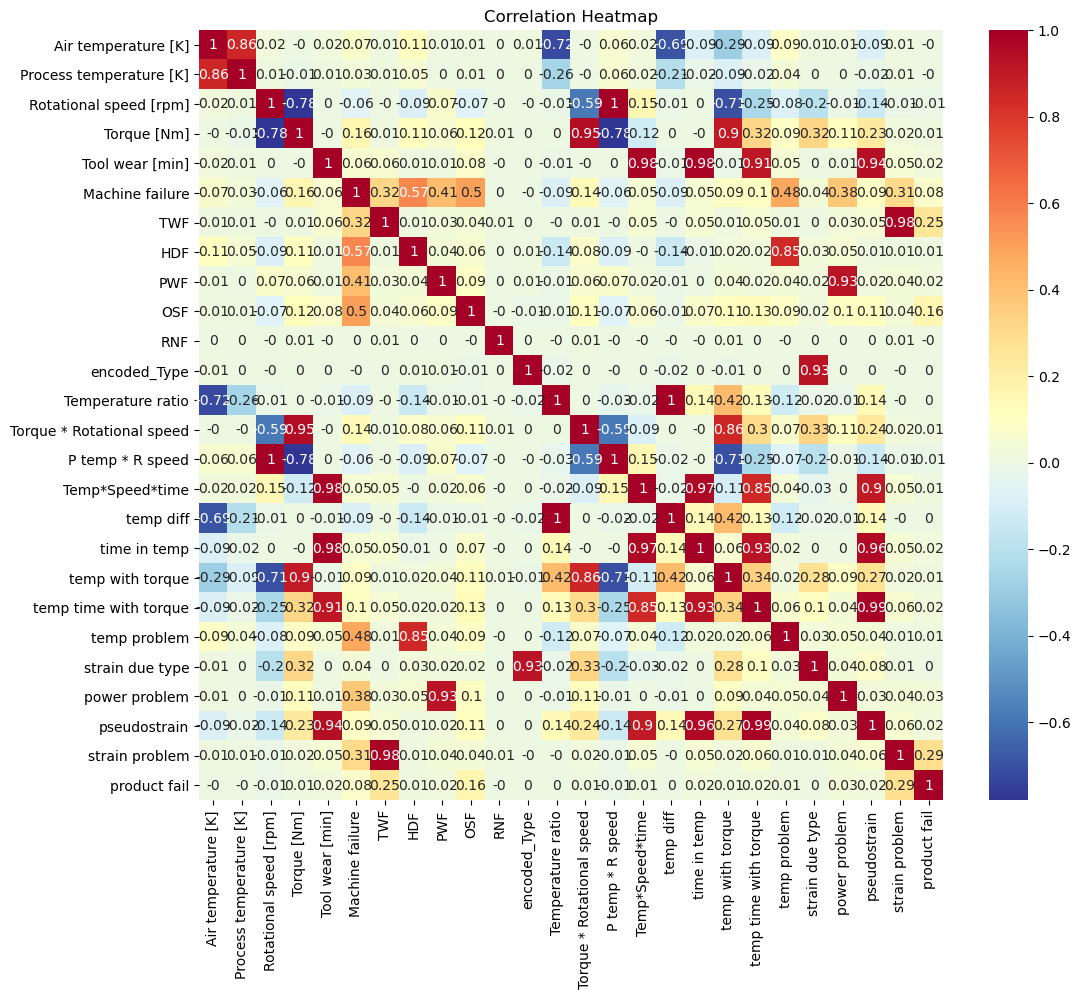

In [24]:
# Including normal corr for all dataframe
correlation_matrix = more.corr().round(2)

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(data=correlation_matrix, annot=True, cmap='RdYlBu_r')
plt.title('Correlation Heatmap')
plt.show()

In [33]:
cat_fine = CatBoostClassifier(iterations= 582, learning_rate= 0.128616224862828, depth= 4, l2_leaf_reg= 8.951134570152803, border_count= 218)
xgb_fine = xgb.XGBClassifier(booster='dart', reg_lambda=0.7354948678403086, reg_alpha=0.5445795572773597, learning_rate=0.1391533241556156)
lgb_fine = lgb.LGBMClassifier(boosting_type= 'dart', lambda_l1= 2.591803588509324, lambda_l2= 1.606580763347382, num_leaves= 886, learning_rate= 0.05927595667362759, feature_fraction= 0.49552064764176496, bagging_fraction= 0.835517178013808, bagging_freq= 9, min_child_samples= 44)
ada_fine = AdaBoostClassifier(n_estimators= 775, learning_rate= 0.4794109711543849, algorithm= 'SAMME.R')

In [17]:
# Split into x and y also remove symbol from x
X_more = more.drop('Machine failure', axis=1)
y = more['Machine failure']

cat_fine.fit(X_more, y)
# Get the feature importances
feature_importances = cat_fine.feature_importances_

# Create a dataframe to store feature importance values
importance_df = pd.DataFrame({'Feature': X_more.columns, 'Importance': feature_importances})

# Sort the dataframe by importance values in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importance dataframe
print(importance_df)

0:	learn: 0.4122938	total: 149ms	remaining: 1m 26s
1:	learn: 0.2476755	total: 157ms	remaining: 45.6s
2:	learn: 0.1547457	total: 166ms	remaining: 32s
3:	learn: 0.1063861	total: 174ms	remaining: 25.1s
4:	learn: 0.0772099	total: 181ms	remaining: 20.9s
5:	learn: 0.0586284	total: 189ms	remaining: 18.2s
6:	learn: 0.0477189	total: 197ms	remaining: 16.2s
7:	learn: 0.0403305	total: 205ms	remaining: 14.7s
8:	learn: 0.0353343	total: 214ms	remaining: 13.6s
9:	learn: 0.0322188	total: 221ms	remaining: 12.7s
10:	learn: 0.0297757	total: 230ms	remaining: 11.9s
11:	learn: 0.0278622	total: 238ms	remaining: 11.3s
12:	learn: 0.0266453	total: 247ms	remaining: 10.8s
13:	learn: 0.0255538	total: 255ms	remaining: 10.3s
14:	learn: 0.0248997	total: 263ms	remaining: 9.96s
15:	learn: 0.0241749	total: 272ms	remaining: 9.63s
16:	learn: 0.0237268	total: 280ms	remaining: 9.31s
17:	learn: 0.0234451	total: 289ms	remaining: 9.04s
18:	learn: 0.0231148	total: 297ms	remaining: 8.8s
19:	learn: 0.0228236	total: 307ms	remaining

In [39]:
X_more.columns = X_more.columns.astype(str)
# Replace problematic characters in feature names
X_more.columns = X_more.columns.str.replace('[', '_')
X_more.columns = X_more.columns.str.replace(']', '_')

C:\Users\logan\AppData\Local\Temp\ipykernel_7308\3263744692.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_more.columns = X_more.columns.str.replace('[', '_')
C:\Users\logan\AppData\Local\Temp\ipykernel_7308\3263744692.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_more.columns = X_more.columns.str.replace(']', '_')


In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_more, y, test_size=0.2, random_state=42)

In [35]:
cat_fine.fit(X_train,y_train)
y_pred_cat_more = cat_fine.predict_proba(X_val)[:, 1]
roc_auc_cat_more = roc_auc_score(y_val, y_pred_cat_more)


print(roc_auc_cat_more)

0:	learn: 0.4120940	total: 12.6ms	remaining: 7.31s
1:	learn: 0.2462215	total: 24ms	remaining: 6.96s
2:	learn: 0.1532317	total: 34.6ms	remaining: 6.68s
3:	learn: 0.1051975	total: 43.1ms	remaining: 6.22s
4:	learn: 0.0761920	total: 51.9ms	remaining: 5.99s
5:	learn: 0.0596995	total: 59ms	remaining: 5.66s
6:	learn: 0.0475257	total: 68.3ms	remaining: 5.61s
7:	learn: 0.0397734	total: 76.1ms	remaining: 5.46s
8:	learn: 0.0351291	total: 84.1ms	remaining: 5.35s
9:	learn: 0.0318212	total: 91.2ms	remaining: 5.21s
10:	learn: 0.0296270	total: 101ms	remaining: 5.24s
11:	learn: 0.0275962	total: 109ms	remaining: 5.16s
12:	learn: 0.0264490	total: 116ms	remaining: 5.1s
13:	learn: 0.0252445	total: 124ms	remaining: 5.04s
14:	learn: 0.0243698	total: 135ms	remaining: 5.1s
15:	learn: 0.0236785	total: 144ms	remaining: 5.11s
16:	learn: 0.0232445	total: 154ms	remaining: 5.1s
17:	learn: 0.0227855	total: 163ms	remaining: 5.11s
18:	learn: 0.0224025	total: 174ms	remaining: 5.16s
19:	learn: 0.0221265	total: 183ms	rema

In [41]:
#Ensemble set up to test
ensemble = VotingClassifier(
    estimators=[('xgb', xgb_fine), ('lgbm', lgb_fine), ('catboost', cat_fine), ('adaboost', ada_fine)],
    voting='soft'  
)

ensemble.fit(X_train, y_train)
y_pred_ens_more = ensemble.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_ens_more)

[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0:	learn: 0.4120940	total: 11.9ms	remaining: 6.9s
1:	learn: 0.2462215	total: 25.3ms	remaining: 7.34s
2:	learn: 0.1532317	total: 35.1ms	remaining: 6.78s
3:	learn: 0.1051975	total: 43.2ms	remaining: 6.25s
4:	learn: 0.0761920	total: 51ms	remaining: 5.88s
5:	learn: 0.0596995	total: 57.9ms	remaining: 5.56s
6:	learn: 0.0475257	total

In [42]:
print(roc_auc)

0.9679655059276513


In [43]:
#RFE for the new one
# Create RFE object
rfe = RFE(estimator=cat_fine, n_features_to_select=13)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected feature indices
selected_indices = rfe.get_support(indices=True)

# Select the corresponding feature names
selected_features = X_train.columns[selected_indices]

# Subset the training and validation data with selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

0:	learn: 0.4120940	total: 10.2ms	remaining: 5.95s
1:	learn: 0.2462215	total: 20.3ms	remaining: 5.87s
2:	learn: 0.1532317	total: 31.6ms	remaining: 6.11s
3:	learn: 0.1051975	total: 43.3ms	remaining: 6.26s
4:	learn: 0.0761920	total: 53ms	remaining: 6.12s
5:	learn: 0.0596995	total: 62.3ms	remaining: 5.98s
6:	learn: 0.0475257	total: 72ms	remaining: 5.91s
7:	learn: 0.0397734	total: 78.6ms	remaining: 5.64s
8:	learn: 0.0351291	total: 86.9ms	remaining: 5.53s
9:	learn: 0.0318212	total: 94.5ms	remaining: 5.41s
10:	learn: 0.0296270	total: 103ms	remaining: 5.37s
11:	learn: 0.0275962	total: 110ms	remaining: 5.23s
12:	learn: 0.0264490	total: 119ms	remaining: 5.2s
13:	learn: 0.0252445	total: 126ms	remaining: 5.13s
14:	learn: 0.0243698	total: 134ms	remaining: 5.08s
15:	learn: 0.0236785	total: 142ms	remaining: 5.02s
16:	learn: 0.0232445	total: 152ms	remaining: 5.05s
17:	learn: 0.0227855	total: 161ms	remaining: 5.04s
18:	learn: 0.0224025	total: 170ms	remaining: 5.02s
19:	learn: 0.0221265	total: 178ms	re

In [44]:
print(X_train_selected.columns)

Index(['Air temperature _K_', 'Rotational speed _rpm_', 'Torque _Nm_',
       'Tool wear _min_', 'HDF', 'PWF', 'OSF', 'Temperature ratio',
       'Torque * Rotational speed', 'P temp * R speed', 'time in temp',
       'strain due type', 'strain problem'],
      dtype='object')


In [47]:
ensemble.fit(X_train_selected, y_train)
y_pred_ens_rfe_more = ensemble.predict_proba(X_val_selected)[:, 1]
roc_auc_enrfe_more = roc_auc_score(y_val, y_pred_ens_rfe_more)

cat_fine.fit(X_train_selected, y_train)
y_pred_cat_rfe_more = cat_fine.predict_proba(X_val_selected)[:, 1]
roc_auc_cat_more = roc_auc_score(y_val, y_pred_cat_rfe_more)

print(roc_auc_enrfe_more)
print(roc_auc_cat_more)

[LightGBM] [Warning] feature_fraction is set=0.49552064764176496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49552064764176496
[LightGBM] [Warning] lambda_l1 is set=2.591803588509324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.591803588509324
[LightGBM] [Warning] bagging_fraction is set=0.835517178013808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835517178013808
[LightGBM] [Warning] lambda_l2 is set=1.606580763347382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.606580763347382
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
0:	learn: 0.4169376	total: 11ms	remaining: 6.38s
1:	learn: 0.2467409	total: 22.1ms	remaining: 6.42s
2:	learn: 0.1634002	total: 31.3ms	remaining: 6.03s
3:	learn: 0.1079654	total: 39ms	remaining: 5.64s
4:	learn: 0.0778752	total: 48.1ms	remaining: 5.54s
5:	learn: 0.0592765	total: 56.3ms	remaining: 5.4s
6:	learn: 0.0471299	total: 

In [46]:
print(roc_auc_enrfe_more)

0.9685556484423298


In [53]:
# Testing set stuff
tmor = testing.copy()
tmor['temp diff'] = tmor['Process temperature _K_'] - tmor['Air temperature _K_']
tmor['time in temp'] = tmor['temp diff'] * tmor['Tool wear _min_']
tmor['temp with torque'] = tmor['temp diff'] * tmor['Torque _Nm_']
tmor['temp time with torque'] = tmor['time in temp'] * tmor['Torque _Nm_']
tmor['temp problem'] = tmor['time in temp'] * tmor['HDF']
tmor['strain due type'] = tmor['Torque * Rotational speed'] * tmor['encoded_Type']
tmor['power problem'] = tmor['Torque * Rotational speed'] * tmor['PWF']
tmor['pseudostrain'] = tmor['time in temp'] * tmor['Torque * Rotational speed']
tmor['strain problem'] = tmor['Torque * Rotational speed'] * tmor['TWF']
tmor['product fail'] = tmor['TWF'] * tmor['OSF']


In [54]:
# Transforming X and testing with those features
X_more_rfe = X_more[selected_features]
test_more_rfe = tmor[selected_features]

In [59]:
cat_fine.fit(X_more, y)
y_pred_cat_more_t = cat_fine.predict(tmor)


submission_df_cat_more = pd.DataFrame({'id': test['id'], 'Machine failure': y_pred_cat_more_t})
submission_df_cat_more.to_csv('submission_cat_more.csv', index=False)

0:	learn: 0.4122938	total: 17.2ms	remaining: 9.99s
1:	learn: 0.2476755	total: 30.2ms	remaining: 8.74s
2:	learn: 0.1547457	total: 42.2ms	remaining: 8.15s
3:	learn: 0.1063861	total: 54.8ms	remaining: 7.92s
4:	learn: 0.0772099	total: 67.2ms	remaining: 7.76s
5:	learn: 0.0586284	total: 79.5ms	remaining: 7.63s
6:	learn: 0.0477189	total: 92.8ms	remaining: 7.62s
7:	learn: 0.0403305	total: 104ms	remaining: 7.49s
8:	learn: 0.0353343	total: 118ms	remaining: 7.48s
9:	learn: 0.0322188	total: 131ms	remaining: 7.48s
10:	learn: 0.0297757	total: 144ms	remaining: 7.46s
11:	learn: 0.0278622	total: 157ms	remaining: 7.46s
12:	learn: 0.0266453	total: 170ms	remaining: 7.44s
13:	learn: 0.0255538	total: 183ms	remaining: 7.42s
14:	learn: 0.0248997	total: 196ms	remaining: 7.42s
15:	learn: 0.0241749	total: 210ms	remaining: 7.41s
16:	learn: 0.0237268	total: 223ms	remaining: 7.43s
17:	learn: 0.0234451	total: 237ms	remaining: 7.44s
18:	learn: 0.0231148	total: 253ms	remaining: 7.49s
19:	learn: 0.0228236	total: 265ms	

In [60]:
cat_fine.fit(X_more_rfe, y)
y_pred_cat_more_ref = cat_fine.predict(test_more_rfe)
submission_df_cat_more_rfe = pd.DataFrame({'id': test['id'], 'Machine failure': y_pred_cat_more_ref})
submission_df_cat_more_rfe.to_csv('submission_cat_more_rfe.csv', index=False)

0:	learn: 0.4175979	total: 10.4ms	remaining: 6.01s
1:	learn: 0.2479577	total: 20ms	remaining: 5.79s
2:	learn: 0.1644576	total: 30.7ms	remaining: 5.92s
3:	learn: 0.1090240	total: 40ms	remaining: 5.78s
4:	learn: 0.0789083	total: 50.6ms	remaining: 5.84s
5:	learn: 0.0594255	total: 61.4ms	remaining: 5.89s
6:	learn: 0.0476015	total: 70.3ms	remaining: 5.77s
7:	learn: 0.0400656	total: 80.5ms	remaining: 5.77s
8:	learn: 0.0355037	total: 90.9ms	remaining: 5.78s
9:	learn: 0.0324242	total: 99.2ms	remaining: 5.67s
10:	learn: 0.0301091	total: 110ms	remaining: 5.69s
11:	learn: 0.0283075	total: 119ms	remaining: 5.67s
12:	learn: 0.0270117	total: 129ms	remaining: 5.65s
13:	learn: 0.0258791	total: 139ms	remaining: 5.62s
14:	learn: 0.0252921	total: 149ms	remaining: 5.65s
15:	learn: 0.0248084	total: 160ms	remaining: 5.66s
16:	learn: 0.0240606	total: 172ms	remaining: 5.72s
17:	learn: 0.0236389	total: 182ms	remaining: 5.71s
18:	learn: 0.0233160	total: 192ms	remaining: 5.69s
19:	learn: 0.0228839	total: 202ms	r

In [63]:
# New catboost stuff
# Catboost with optuna
def objective_cat(trial):
    params = {
        'scale_pos_weight': 54,
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': False,
        'task_type': 'GPU'
    }

    model_cat = CatBoostClassifier(**params)

    # Perform k-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores_cat = []
    for train_idx, val_idx in kfold.split(X_more_rfe, y):
        X_train, X_val = X_more_rfe.iloc[train_idx], X_more_rfe.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_pool = Pool(data=X_train, label=y_train)
        val_pool = Pool(data=X_val, label=y_val)

        model_cat.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=False)

        y_pred_cat = model_cat.predict_proba(X_val)[:, 1]
        score_cat = roc_auc_score(y_val, y_pred_cat)
        scores_cat.append(score_cat)

    avg_score_cat = sum(scores_cat) / len(scores_cat)
    return avg_score_cat


In [64]:
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=200)

best_params_cat = study_cat.best_params
best_score_cat = study_cat.best_value

[I 2023-06-15 19:00:54,366] A new study created in memory with name: no-name-a666a235-c914-4eb9-b1fe-b097d5ec29e2
[I 2023-06-15 19:01:13,760] Trial 0 finished with value: 0.9688382836073351 and parameters: {'iterations': 865, 'learning_rate': 0.10931210062916102, 'depth': 5, 'l2_leaf_reg': 4.19622853590113, 'border_count': 199}. Best is trial 0 with value: 0.9688382836073351.
[I 2023-06-15 19:01:25,458] Trial 1 finished with value: 0.9664338380931928 and parameters: {'iterations': 933, 'learning_rate': 0.35356956897926634, 'depth': 5, 'l2_leaf_reg': 0.5027907204691237, 'border_count': 66}. Best is trial 0 with value: 0.9688382836073351.
[I 2023-06-15 19:01:38,559] Trial 2 finished with value: 0.9681422610113725 and parameters: {'iterations': 775, 'learning_rate': 0.20083394554619038, 'depth': 5, 'l2_leaf_reg': 7.160975660964723, 'border_count': 114}. Best is trial 0 with value: 0.9688382836073351.
[I 2023-06-15 19:01:56,434] Trial 3 finished with value: 0.962908769912549 and parameters

In [65]:
print(best_params_cat)

{'iterations': 591, 'learning_rate': 0.08205600468017794, 'depth': 4, 'l2_leaf_reg': 9.80389582697133, 'border_count': 252}


In [71]:
X_train, X_val, y_train, y_val = train_test_split(X_more_rfe, y, test_size=0.2, random_state=42)


final_cat = CatBoostClassifier(**best_params_cat, task_type= 'GPU')

In [77]:


# Create RFE object
rfe_10 = RFE(estimator=final_cat, n_features_to_select=10)

# Fit RFE on the training data
rfe_10.fit(X_train, y_train)

# Get the selected feature indices
selected_indices_10 = rfe_10.get_support(indices=True)

# Select the corresponding feature names
selected_features_10 = X_train.columns[selected_indices_10]

# Subset the training and validation data with selected features
X_train_selected_10 = X_train[selected_features_10]
X_val_selected_10 = X_val[selected_features_10]


0:	learn: 0.4920110	total: 5.65ms	remaining: 3.33s
1:	learn: 0.3509756	total: 10.5ms	remaining: 3.08s
2:	learn: 0.2589295	total: 16.3ms	remaining: 3.19s
3:	learn: 0.1906975	total: 21.1ms	remaining: 3.1s
4:	learn: 0.1438065	total: 25.9ms	remaining: 3.03s
5:	learn: 0.1113124	total: 31.3ms	remaining: 3.05s
6:	learn: 0.0885316	total: 36.8ms	remaining: 3.07s
7:	learn: 0.0728273	total: 42.1ms	remaining: 3.07s
8:	learn: 0.0613901	total: 47.6ms	remaining: 3.08s
9:	learn: 0.0531561	total: 53.2ms	remaining: 3.09s
10:	learn: 0.0465159	total: 58.1ms	remaining: 3.06s
11:	learn: 0.0418496	total: 63.1ms	remaining: 3.04s
12:	learn: 0.0382785	total: 68.5ms	remaining: 3.05s
13:	learn: 0.0355112	total: 74.4ms	remaining: 3.06s
14:	learn: 0.0332105	total: 81.1ms	remaining: 3.11s
15:	learn: 0.0310811	total: 87.3ms	remaining: 3.14s
16:	learn: 0.0294353	total: 92.9ms	remaining: 3.14s
17:	learn: 0.0282989	total: 99.8ms	remaining: 3.18s
18:	learn: 0.0271207	total: 105ms	remaining: 3.15s
19:	learn: 0.0262962	tot

In [78]:
print(X_train_selected_10.columns)

Index(['Air temperature _K_', 'Rotational speed _rpm_', 'Torque _Nm_',
       'Tool wear _min_', 'HDF', 'PWF', 'OSF', 'Temperature ratio',
       'P temp * R speed', 'strain problem'],
      dtype='object')


In [74]:
final_cat.fit(X_more_rfe, y)
final_preds = final_cat.predict(test_more_rfe)
submission_df_final_preds = pd.DataFrame({'id': test['id'], 'Machine failure': final_preds})
submission_df_final_preds.to_csv('submission_cat_tuned.csv', index=False)

0:	learn: 0.4930373	total: 5.72ms	remaining: 3.38s
1:	learn: 0.3524889	total: 11.4ms	remaining: 3.36s
2:	learn: 0.2608019	total: 18.3ms	remaining: 3.59s
3:	learn: 0.1924884	total: 23.3ms	remaining: 3.42s
4:	learn: 0.1481102	total: 30.6ms	remaining: 3.59s
5:	learn: 0.1146402	total: 36.8ms	remaining: 3.58s
6:	learn: 0.0911581	total: 43.4ms	remaining: 3.62s
7:	learn: 0.0744690	total: 49.3ms	remaining: 3.59s
8:	learn: 0.0630177	total: 54.2ms	remaining: 3.5s
9:	learn: 0.0540585	total: 60.9ms	remaining: 3.54s
10:	learn: 0.0474407	total: 67.4ms	remaining: 3.56s
11:	learn: 0.0428076	total: 75ms	remaining: 3.62s
12:	learn: 0.0389955	total: 82ms	remaining: 3.65s
13:	learn: 0.0357547	total: 87.2ms	remaining: 3.59s
14:	learn: 0.0334731	total: 93ms	remaining: 3.57s
15:	learn: 0.0317503	total: 98.5ms	remaining: 3.54s
16:	learn: 0.0301829	total: 104ms	remaining: 3.5s
17:	learn: 0.0288050	total: 109ms	remaining: 3.48s
18:	learn: 0.0277000	total: 115ms	remaining: 3.46s
19:	learn: 0.0270025	total: 120ms

In [79]:
# Transforming X and testing with those features
X_10 = X_more_rfe[selected_features_10]
test_10 = test_more_rfe[selected_features_10]

In [80]:
final_cat.fit(X_10, y)
final_preds_10 = final_cat.predict(test_10)
submission_df_final_preds_10 = pd.DataFrame({'id': test['id'], 'Machine failure': final_preds_10})
submission_df_final_preds_10.to_csv('submission_cat_tuned_10.csv', index=False)

0:	learn: 0.5052120	total: 6.47ms	remaining: 3.81s
1:	learn: 0.3609667	total: 13.9ms	remaining: 4.08s
2:	learn: 0.2612846	total: 19.5ms	remaining: 3.82s
3:	learn: 0.1928286	total: 25ms	remaining: 3.66s
4:	learn: 0.1483572	total: 30.8ms	remaining: 3.61s
5:	learn: 0.1148218	total: 36.6ms	remaining: 3.56s
6:	learn: 0.0912957	total: 43.1ms	remaining: 3.6s
7:	learn: 0.0745766	total: 48.9ms	remaining: 3.56s
8:	learn: 0.0631166	total: 54.5ms	remaining: 3.52s
9:	learn: 0.0541398	total: 61.3ms	remaining: 3.56s
10:	learn: 0.0475098	total: 67.7ms	remaining: 3.57s
11:	learn: 0.0425558	total: 73ms	remaining: 3.52s
12:	learn: 0.0387764	total: 78.4ms	remaining: 3.48s
13:	learn: 0.0357740	total: 84.6ms	remaining: 3.49s
14:	learn: 0.0334129	total: 89.5ms	remaining: 3.44s
15:	learn: 0.0315296	total: 94.4ms	remaining: 3.39s
16:	learn: 0.0298954	total: 101ms	remaining: 3.39s
17:	learn: 0.0287862	total: 106ms	remaining: 3.36s
18:	learn: 0.0277864	total: 111ms	remaining: 3.33s
19:	learn: 0.0268411	total: 11

In [81]:
# Create RFE object
rfe_8 = RFE(estimator=final_cat, n_features_to_select=8)

# Fit RFE on the training data
rfe_8.fit(X_train, y_train)

# Get the selected feature indices
selected_indices_8 = rfe_8.get_support(indices=True)

# Select the corresponding feature names
selected_features_8 = X_train.columns[selected_indices_8]

# Subset the training and validation data with selected features
X_train_selected_8 = X_train[selected_features_8]
X_val_selected_8 = X_val[selected_features_8]


0:	learn: 0.4920110	total: 6.77ms	remaining: 4s
1:	learn: 0.3509756	total: 13.8ms	remaining: 4.08s
2:	learn: 0.2589295	total: 21.4ms	remaining: 4.19s
3:	learn: 0.1906975	total: 27.9ms	remaining: 4.1s
4:	learn: 0.1438065	total: 36.1ms	remaining: 4.23s
5:	learn: 0.1113124	total: 42.6ms	remaining: 4.15s
6:	learn: 0.0885316	total: 49.8ms	remaining: 4.15s
7:	learn: 0.0728273	total: 56.1ms	remaining: 4.09s
8:	learn: 0.0613901	total: 63ms	remaining: 4.08s
9:	learn: 0.0531561	total: 70.3ms	remaining: 4.08s
10:	learn: 0.0465159	total: 75.6ms	remaining: 3.99s
11:	learn: 0.0418496	total: 83.1ms	remaining: 4.01s
12:	learn: 0.0382785	total: 90.1ms	remaining: 4s
13:	learn: 0.0355112	total: 96ms	remaining: 3.95s
14:	learn: 0.0332105	total: 103ms	remaining: 3.95s
15:	learn: 0.0310811	total: 109ms	remaining: 3.91s
16:	learn: 0.0294353	total: 116ms	remaining: 3.91s
17:	learn: 0.0282989	total: 124ms	remaining: 3.94s
18:	learn: 0.0271207	total: 129ms	remaining: 3.89s
19:	learn: 0.0262962	total: 137ms	rema

In [82]:
print(X_train_selected_8.columns)

Index(['Air temperature _K_', 'Rotational speed _rpm_', 'Torque _Nm_',
       'Tool wear _min_', 'HDF', 'PWF', 'OSF', 'Temperature ratio'],
      dtype='object')


In [83]:
# Transforming X and testing with those features
X_8 = X_more_rfe[selected_features_8]
test_8 = test_more_rfe[selected_features_8]

In [84]:
final_cat.fit(X_8, y)
final_preds_8 = final_cat.predict(test_8)
submission_df_final_preds_8 = pd.DataFrame({'id': test['id'], 'Machine failure': final_preds_8})
submission_df_final_preds_8.to_csv('submission_cat_tuned_8.csv', index=False)

0:	learn: 0.5052120	total: 6.68ms	remaining: 3.94s
1:	learn: 0.3686534	total: 12.6ms	remaining: 3.7s
2:	learn: 0.2708729	total: 18ms	remaining: 3.52s
3:	learn: 0.2048552	total: 24.1ms	remaining: 3.54s
4:	learn: 0.1585819	total: 30.1ms	remaining: 3.53s
5:	learn: 0.1261742	total: 35ms	remaining: 3.41s
6:	learn: 0.1013195	total: 40ms	remaining: 3.33s
7:	learn: 0.0846832	total: 45.5ms	remaining: 3.31s
8:	learn: 0.0725794	total: 51.2ms	remaining: 3.31s
9:	learn: 0.0623576	total: 57.2ms	remaining: 3.32s
10:	learn: 0.0557150	total: 63.5ms	remaining: 3.35s
11:	learn: 0.0507811	total: 68.8ms	remaining: 3.32s
12:	learn: 0.0463446	total: 75.6ms	remaining: 3.36s
13:	learn: 0.0432083	total: 82.3ms	remaining: 3.39s
14:	learn: 0.0405875	total: 88.1ms	remaining: 3.38s
15:	learn: 0.0384589	total: 93.9ms	remaining: 3.37s
16:	learn: 0.0367096	total: 99.4ms	remaining: 3.35s
17:	learn: 0.0352435	total: 105ms	remaining: 3.34s
18:	learn: 0.0341793	total: 111ms	remaining: 3.33s
19:	learn: 0.0333072	total: 116